# Предсказание ухода клиентов у оператора связи

Краткое описание проекта:

**Компания:** Наш заказчик - это оператор связи, специализирующийся на предоставлении стационарной телефонной связи, интернет-подключении и дополнительных сервисах, таких как антивирусная защита, выделенная линия технической поддержки, облачное хранилище файлов и стриминговое телевидение.

**Цель проекта:** Наша задача заключается в разработке модели машинного обучения, которая способна предсказывать, уйдут ли клиенты из компании, предоставляющей услуги в сфере интернета и связи.

**Исходные данные:** Мы используем персональные данные клиентов, актуальные на 1 февраля 2020 года, а также информацию о подключенных услугах и условиях оплаты.

**Требования к модели:** Мы устанавливаем следующее требование для модели: метрика AUC-ROC на тестовых данных должна составлять не менее 0.85.

**Описание данных**

Мы располагаем 4 наборами данных:

1. **contract.csv** - детали договора
2. **personal.csv** - личная информация клиента
3. **internet.csv** - сведения об интернет-услугах
4. **phone.csv** - информация по телефонной связи

**contract.csv**

В этом файле содержится следующая информация:

- **customerID**: идентификатор клиента
- **BeginDate**: дата начала контракта
- **EndDate**: дата завершения контракта
- **Type**: оплаты (ежемесячно или за определенный период)
- **PaperlessBilling**: получение клиентом электронного счета
- **PaymentMethod**: методы оплаты
- **MonthlyCharges**: ежемесячные сборы
- **TotalCharges**: общая сумма платежей

**personal.csv**

Здесь представлены следующие данные о клиентах:

- **customerID**: идентификатор клиента
- **gender**: пол
- **Partner**: пожилой ли человек
- **Dependents**: имеет ли работу

**internet.csv**

Данный файл содержит информацию об интернет-услугах:

- **customerID**: идентификатор клиента
- **InternetService**: типы интернет-соединения
- **OnlineSecurity**: блокировка опасных сайтов
- **OnlineBackup**: облачное хранилище
- **DeviceProtection**: антивирус
- **TechSupport**: выделенная техническая поддержка
- **StreamingTV**: стриминговое ТВ
- **StreamingMovies**: каталог фильмов

**phone.csv**

Этот файл включает в себя данные о телефонных услугах:

- **customerID**: идентификатор клиента
- **MultipleLines**: наличие многоканальной связи (отдельная телефонная услуга или в комплексе с интернетом)

# План работы

**1. Подготовить данные для анализа**
- Проверить пропуски, дубликаты и формат данных.
- Привести данные к нужному виду.

**2. Провести разведывательный анализ**
- Изучить распределение целевого признака.
- Анализировать количественные признаки.
- Рассмотреть распределение типа услуг:
  - Среди тех, кто ушел.
  - Среди тех, кто остался.
- Рассмотреть распределение типа оплаты услуг:
  - Среди тех, кто ушел.
  - Среди тех, кто остался.

**3. Обучение и тестирование модели**
- Подготовить данные для обучения: разделение на обучающую и тестовую выборки с последующим кодированием.
- Выбрать модели для обучения.
- Оценить качество моделей по времени обучения и метрике roc-auc.
- Выбрать лучшую модель и рассмотреть финальную оценку метрики roc-auc.

**4. Заключение**
- Проверить выполнение плана.
- Описать возникшие трудности.
- Выделить ключевые этапы в решении задачи.
- Описать итоговую модель и её качество.


## Подготовка данных для анализа

### Загрузка данных

**Подключаем библиотеки:**

 - pandas - для работы с таблицами
 - seaborn - для визуализации данных
 - sklearn - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

In [1]:
pip install phik==0.12.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт библиотек для работы с данными и визуализации
import pandas as pd  # pandas - библиотека для работы с данными
import seaborn as sns  # seaborn - библиотека для визуализации данных
import matplotlib.pyplot as plt  # matplotlib - библиотека для создания графиков
import numpy as np  # numpy - библиотека для работы с числовыми данными

# Импорт функций и классов для моделирования
from catboost import CatBoostClassifier  # CatBoostClassifier - модель CatBoost
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier - модель случайного леса
from sklearn.pipeline import Pipeline  # Pipeline - конвейер обработки данных

# Импорт дополнительных библиотек и модулей
from lightgbm import LGBMClassifier  # LGBMClassifier - модель LightGBM
from sklearn.dummy import DummyClassifier  # DummyClassifier - модель Dummy (для сравнения)

# Импорт библиотеки phik для анализа корреляции
import phik  

# Импорт функций для оценки корреляции
from phik import report  # Импортируем функцию для отчета о корреляции
from phik.report import plot_correlation_matrix

# Импорт функций и классов для оценки модели
from sklearn.metrics import (auc, roc_curve, roc_auc_score, 
                             accuracy_score, precision_score, 
                             confusion_matrix)

# Импортируем класс Pool из библиотеки CatBoost
from catboost import Pool

# Импорт функций для подбора параметров и разделения данных
from sklearn.model_selection import GridSearchCV, train_test_split

# Импорт функций для кодирования категориальных переменных и стандартизации числовых данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Отключение некритических предупреждений
import warnings  # Импортируем библиотеку warnings для управления предупреждениями
warnings.filterwarnings("ignore")  # Отключаем предупреждения

# Сброс ограничения на количество выводимых столбцов, чтобы просмотреть все столбцы в DataFrame
pd.set_option('display.max_columns', None)  # Устанавливаем опцию для отображения всех столбцов в DataFrame

RANDOM_STATE=11092023 #280823

In [8]:
# Выводим информацию о версиях установленных библиотек
!pip show pandas seaborn numpy matplotlib phik catboost

Name: pandas
Version: 2.1.4
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials 

In [9]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/contract_new.csv'
try:
    df_contract = pd.read_csv('/datasets/contract_new.csv')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/contract_new.csv'
    df_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_contract'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [10]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/internet_new.csv'
try:
    df_internet = pd.read_csv('/datasets/internet_new.csv')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/internet_new.csv'
    df_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_internet'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [11]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/personal_new.csv'
try:
    df_personal = pd.read_csv('/datasets/personal_new.csv')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/personal_new.csv'
    df_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_personal'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

In [12]:
# Попытаемся прочитать CSV-файл из локального пути '/datasets/phone_new.csv'
try:
    df_phone = pd.read_csv('/datasets/phone_new.csv')
    
# Если не удалось прочитать файл локально, то выполняем код в блоке except
except:
    # Пробуем прочитать CSV-файл из удаленного источника по URL 'https://code.s3.yandex.net/datasets/phone_new.csv'
    df_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

# В данном случае, если файл успешно загружен, данные будут храниться в переменной 'df_phone'
# Если первая попытка чтения из локального пути завершится успешно, блок 'except' не будет выполнен.

### Сделаем первичный анализ данных

- Для всех полей преобразуем данные в удобный для обработки формат (строки в числовые категории, datetime и др.)
- При наличии, обработаем пропуски и выбросы

**Посмотрим на датасет с деталями договора.**

In [13]:
# Выбираем случайные 15 строк из DataFrame с именем df_contract.
# Параметр random_state задаёт начальное значение для генератора случайных чисел,
# что обеспечивает воспроизводимость случайной выборки.
df_contract.sample(25, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1683,0354-VXMJC,2018-03-01,No,Two year,No,Credit card (automatic),19.60,450.8
2891,0495-RVCBF,2019-10-01,No,Month-to-month,Yes,Electronic check,79.70,321.99
6729,2256-YLYLP,2014-06-01,No,Two year,Yes,Bank transfer (automatic),72.95,5258.24
152,1679-JRFBR,2014-04-01,2016-09-01,One year,Yes,Credit card (automatic),108.15,3387.26
5134,8010-EZLOU,2018-08-01,No,Month-to-month,Yes,Electronic check,80.20,1443.6
965,9889-TMAHG,2019-03-01,No,Month-to-month,No,Credit card (automatic),100.30,1169.5
3488,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.90,539.1
3453,0326-VDYXE,2014-04-01,2017-07-01,One year,Yes,Electronic check,97.65,3808.35
5468,6437-UKHMV,2019-03-01,No,Month-to-month,Yes,Electronic check,79.70,885.47
6557,8709-KRDVL,2017-05-01,No,Month-to-month,Yes,Electronic check,100.00,3300.0


In [7]:
# Метод `describe()` для DataFrame из библиотеки pandas предоставляет статистическое описание каждого столбца.
# Это включает в себя такие метрики, как среднее значение, стандартное отклонение, минимальное и максимальное значения,
# а также 25-й, 50-й (медиана) и 75-й процентили.
# Этот метод полезен для получения общего представления о распределении данных в каждом столбце.
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [8]:
# Метод `info()` для DataFrame из библиотеки pandas предоставляет краткую сводку о DataFrame.
# Он отображает следующую информацию:
# - Количество строк и столбцов.
# - Типы данных каждого столбца.
# - Количество непустых (не NaN) значений в каждом столбце.
# - Использование памяти DataFrame.
# Этот метод полезен для быстрого понимания структуры и типов данных DataFrame, а также для определения столбцов с пропущенными значениями.
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [9]:
# 1. Метод `duplicated()` для DataFrame из библиотеки pandas определяет дубликаты строк в DataFrame.
#    Он возвращает Series (последовательность) из булевых значений, где `True` указывает на дубликатную строку, 
#    а `False` на уникальную строку.
# 2. `sum()` подсчитывает количество `True` значений в этой последовательности, что дает общее число дубликатов в DataFrame.

# Этот код вычисляет и возвращает количество дублирующихся строк в DataFrame `df_contract`.
df_contract.duplicated().sum()

0

In [10]:
# приведем столбцы к нижнему регистру
df_contract.columns = map(str.lower, df_contract.columns)

In [11]:
# Выводим названия столбцов датафрейма df_contract
df_contract.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [12]:
# Применем стиль "snake_case" для некоторых столбцов в датафрейме contract_df для большей наглядности и удобства работы
df_contract = df_contract.rename(columns = {
    'customerid' : 'customer_id',        # Приводим имя клиента к единому формату
    'begindate' : 'begin_date',          # Используем нижние подчеркивания для разделения слов в дате заключения договора
    'enddate' : 'end_date',              # Используем нижние подчеркивания для разделения слов в дате расторжения договора
    'paperlessbilling' : 'paperless_billing',   # Улучшаем читаемость названия столбца по электронному чеку
    'paymentmethod' : 'payment_method',  # Используем нижние подчеркивания для разделения слов в методе оплаты
    'monthlycharges' : 'monthly_charges',# Используем нижние подчеркивания для разделения слов в ежемесячных платежах
    'totalcharges' : 'total_charges'     # Используем нижние подчеркивания для разделения слов в общей сумме платежа клиента
})

# Выводим информацию о новом датафрейме после переименования столбцов
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [13]:
# В DataFrame df_contract фильтруем (или извлекаем) строки, где значение в столбце 'TotalCharges' равно пробелу.
# Это позволит нам увидеть строки с пустым значением в данном столбце.
df_contract[df_contract['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Мы выяснили, что столбец `total_charges` представлен как тип данных object, в то время как мы ожидали тип float. Кроме того, в нескольких записях обнаружены пустые значения. Детальный анализ дат показывает, что договоры были оформлены 1 февраля 2020 года, что совпадает с датой нашего экспорта данных. По всей видимости, платежные данные еще не были получены или занесены в систему. Удалим эти записи, так как они не приносят ценности в нашем контексте. Также приведем столбец к нужному формату.

In [14]:
# В DataFrame df_contract оставляем только те строки, где значение в столбце 'TotalCharges' не равно пробелу.
# Таким образом, строки с пробелом в столбце 'TotalCharges' будут исключены из DataFrame.
df_contract = df_contract.loc[df_contract['total_charges'] != ' ']

In [15]:
# Преобразование столбца 'TotalCharges' из типа данных object (или другого типа) в тип float.
# Это позволит проводить числовые операции с данными в этом столбце.
df_contract['total_charges'] = df_contract['total_charges'].astype(float)

# Вывод размерности DataFrame df_contract после преобразования столбца и возможных предыдущих операций.
# Размерность будет представлена в формате (количество строк, количество столбцов).
df_contract.shape

(7032, 8)

In [16]:
# Вывод основной информации о датафрейме df_contract
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


Мы успешно изменили тип данных. Теперь выделим целевой признак в отдельный столбец и приведем столбцы `begin_date` и `end_date` к корректному формату даты. К тому же, нам известно, что данные были выгружены 1 февраля 2020 года. Поэтому, вместо значения "No" в столбце `end_date`, заменим его на дату этой выгрузки.

In [17]:
# Для всех строк в DataFrame df_contract, где значение в столбце 'EndDate' равно "No",
# создаем (или обновляем) столбец 'left_company' и присваиваем ему значение 0.
# Это указывает на то, что клиент еще не покинул компанию.
df_contract.loc[df_contract['end_date'] == 'No', 'left_company'] = 0

# Для всех строк в DataFrame df_contract, где значение в столбце 'EndDate' отлично от "No",
# создаем (или обновляем) столбец 'left_company' и присваиваем ему значение 1.
# Это указывает на то, что клиент покинул компанию.
df_contract.loc[df_contract['end_date'] != 'No', 'left_company'] = 1

# Преобразование столбца "left_company" в формат int64
df_contract['left_company'] = df_contract['left_company'].astype('int64')

In [18]:
# Преобразование значений столбца 'BeginDate' в DataFrame df_contract к формату 
# datetime с использованием метода apply и функции pd.to_datetime.
df_contract['begin_date'] = df_contract['begin_date'].apply(pd.to_datetime)

In [19]:
# Замена всех значений "No" в столбце 'end_date' на дату "2020-02-01". 
# Это делается на основе того, что данные были выгружены 1 февраля 2020 года.
df_contract.end_date = df_contract.end_date.replace('No', '2020-02-01')

In [20]:
# Преобразование значений столбца 'end_date' в DataFrame df_contract к 
# формату datetime с использованием метода apply и функции pd.to_datetime.
df_contract['end_date'] = df_contract['end_date'].apply(pd.to_datetime)

Данные успешно приведены к нужному формату. Далее рассчитаем, сколько времени человек является/являлся нашим клиентом. Впоследствии изучим эти данные подробнее. На текущий момент продолжим подготовку данных для анализа.

In [21]:
# Расчет количества дней, в течение которых человек был клиентом компании. 
# Это делается путем вычитания даты начала контракта ('begin_date') из даты окончания контракта ('end_date').
# Результат (разница между этими датами) преобразуется в количество дней с помощью атрибута '.dt.days'.
# Полученные значения сохраняются в новом столбце 'count_days' DataFrame df_contract.
df_contract['count_days'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [22]:
# Замена значений "No" на 0 и "Yes" на 1 в столбце "paperless_billing"
df_contract['paperless_billing'] = df_contract['paperless_billing'].map({'No': 0, 'Yes': 1})

In [23]:
# Используем метод .head() для вывода первых нескольких строк DataFrame по результату всех преобразований
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left_company,count_days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,1,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,1,Electronic check,70.70,353.50,0,153


**Вывод**

Таблица `contract` представляет собой обзор информации, касающейся контрактных отношений с клиентами:

Содержимое таблицы:

- `customer_id` служит уникальным идентификатором для каждого клиента.
- `begin_date` указывает на дату начала действия контракта.
- `end_date` отображает дату завершения контракта.
- `type` определяет режим оплаты — ежемесячный или за определенный период.
- `paperless_billing` показывает, получает ли клиент счета в электронной форме.
- `payment_method` описывает способы оплаты, которые использует клиент.
- `monthly_charges` представляет собой ежемесячную плату.
- `total_charges` отражает общую сумму платежей.

На основе первичного анализа данных, мы обнаружили, что столбец total_charges имеет тип данных object, хотя ожидалось, что он будет типа float. К тому же, в некоторых записях присутствуют пустые значения. При детальном изучении дат, выяснилось, что эти договоры были заключены 1 февраля 2020 года, совпадающим с датой экспорта наших данных. Вероятно, платежная информация ещё не была обработана или внесена в систему. В связи с этим, мы удалим эти строки, так как они не добавляют ценности для нашего анализа. 

**Посмотрим на датасет с персональными данными клиента.**

In [24]:
# приведем столбцы к нижнему регистру
df_personal.columns = map(str.lower, df_personal.columns)
# Выводим 15 случайных строк из DataFrame df_personal.
# Для воспроизводимости результатов используем параметр random_state, который обеспечивает случайную выборку строк при каждом вызове.
df_personal.sample(15, random_state=RANDOM_STATE)

,customerid,gender,seniorcitizen,partner,dependents
1683,0354-VXMJC,Male,0,Yes,Yes
2891,0495-RVCBF,Female,0,No,No
6729,2256-YLYLP,Male,0,Yes,Yes
152,1679-JRFBR,Female,0,Yes,Yes
5134,8010-EZLOU,Male,1,No,No
965,9889-TMAHG,Male,1,No,No
3488,0003-MKNFE,Male,0,No,No
3453,0326-VDYXE,Female,0,Yes,No
5468,6437-UKHMV,Female,0,No,No
6557,8709-KRDVL,Female,0,No,No


In [25]:
# Отображаем сводную информацию о DataFrame df_personal. 
# Это включает в себя количество непустых значений, тип данных каждого столбца и использование памяти.
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [26]:
# Проверяем наличие дубликатов в DataFrame df_personal, суммируя количество найденных дубликатов.
df_personal.duplicated().sum()

0

In [27]:
# Применем стиль "snake_case" для некоторых столбцов в датафрейме df_personal для большей наглядности и удобства работы
df_personal = df_personal.rename(columns = {'customerid' : 'customer_id',
                                            'seniorcitizen' : 'senior_citizen'})

# Выводим информацию о новом датафрейме после переименования столбцов
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Заменим значения "No" и "Yes" в столбцах partner и dependents на 0 и 1 соответственно.

In [28]:
# Замена значений "No" на 0 и "Yes" на 1 в столбце "partner"
df_personal['partner'] = df_personal['partner'].map({'No': 0, 'Yes': 1})
# Замена значений "No" на 0 и "Yes" на 1 в столбце "dependents"
df_personal['dependents'] = df_personal['dependents'].map({'No': 0, 'Yes': 1})

In [29]:
# Выводим уникальные значения столбца 'gender' с помощью метода .unique()
df_personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

Можно заметить,что столбец `gender` (пока) содержит всего два значения и таким образом считаю возможным также заменить 'Female' и 'Male' на 0 и 1 соответственно.

In [30]:
# Замена значений "Female" на 0 и "Male" на 1 в столбце "streaming_movies"
df_personal['gender'] = df_personal['gender'].map({'Female': 0, 'Male': 1})

In [31]:
# Используем метод .head() для вывода первых нескольких строк DataFrame по результату всех преобразований
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


**Вывод**

Таблица `personal` представляет следующую информацию:

 - `customer_id` — это уникальный код каждого клиента, и в таблице содержится 7043 таких идентификатора.
 - `gender` указывает на пол клиента.
 - `senior_citizen` определяет, пенсионер ли клиент.
 - `partner` дает понимание о наличии у клиента партнера.
 - `dependents` показывает, есть ли у клиента иждивенцы.

**Посмотрим на датасет об интернет-услугах.**

In [32]:
# приведем столбцы к нижнему регистру
df_internet.columns = map(str.lower, df_internet.columns)
# Отображаем 15 случайных строк из DataFrame df_internet, 
# используя предопределенное начальное значение генератора случайных чисел (random_state).
df_internet.sample(15, random_state=RANDOM_STATE)

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
4741,9526-BIHHD,DSL,Yes,No,No,No,No,No
1314,1228-FZFRV,Fiber optic,Yes,No,Yes,No,Yes,Yes
1861,5103-MHMHY,DSL,No,No,No,No,No,No
581,6786-OBWQR,Fiber optic,No,No,No,No,Yes,No
3251,7733-UDMTP,DSL,No,Yes,Yes,No,Yes,Yes
1478,6474-FVJLC,Fiber optic,No,No,No,No,No,Yes
1829,7928-VJYAB,Fiber optic,No,No,No,No,Yes,Yes
5298,1596-OQSPS,DSL,No,Yes,No,No,No,No
1419,6650-VJONK,DSL,No,No,No,No,No,No
1924,9481-SFCQY,DSL,No,No,Yes,No,Yes,No


In [33]:
# Получаем информацию о DataFrame df_internet, включая количество ненулевых значений, типы данных и использование памяти.
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [34]:
# Проверяем количество дубликатов в DataFrame df_internet.
df_internet.duplicated().sum()

0

In [35]:
# Применем стиль "snake_case" для некоторых столбцов в датафрейме df_personal для большей наглядности и удобства работы
df_internet = df_internet.rename(columns = {'customerid' : 'customer_id',
                                            'internetservice' : 'internet_service',
                                            'onlinesecurity' : 'online_security',
                                            'onlinebackup' : 'online_backup',
                                            'deviceprotection' : 'device_protection',
                                            'techsupport' : 'tech_support',
                                            'streamingtv' : 'streaming_tv',
                                            'streamingmovies' : 'streaming_movies'})

# Выводим информацию о новом датафрейме после переименования столбцов
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Заменим значения "No" и "Yes" на 0 и 1 соответственно во всех столбцах где таковые значения имеются.

In [36]:
# Замена значений "No" на 0 и "Yes" на 1 в столбце "online_security"
df_internet['online_security'] = df_internet['online_security'].map({'No': 0, 'Yes': 1})
# Замена значений "No" на 0 и "Yes" на 1 в столбце "online_backup"
df_internet['online_backup'] = df_internet['online_backup'].map({'No': 0, 'Yes': 1})
# Замена значений "No" на 0 и "Yes" на 1 в столбце "device_protection"
df_internet['device_protection'] = df_internet['device_protection'].map({'No': 0, 'Yes': 1})
# Замена значений "No" на 0 и "Yes" на 1 в столбце "tech_support"
df_internet['tech_support'] = df_internet['tech_support'].map({'No': 0, 'Yes': 1})
# Замена значений "No" на 0 и "Yes" на 1 в столбце "streaming_tv"
df_internet['streaming_tv'] = df_internet['streaming_tv'].map({'No': 0, 'Yes': 1})
# Замена значений "No" на 0 и "Yes" на 1 в столбце "streaming_movies"
df_internet['streaming_movies'] = df_internet['streaming_movies'].map({'No': 0, 'Yes': 1})

Можно заметить,что столбец `internet_service` содержит всего два значения и таким образом считаю возможным также заменить 'DSL' и 'Fiber optic' на 0 и 1 соответственно.

In [38]:
# Используем метод .head() для вывода первых нескольких строк DataFrame по результату всех преобразований
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


**Вывод**

Таблица `internet` отображает информацию о дополнительных услугах, которые подключены у клиентов:

- `customer_id` представляет собой уникальный код клиента. Таблица содержит 5517 таких записей. Поскольку это число меньше общего числа клиентов (7043), в последующем мы будем исходить из предположения, что отсутствие информации о клиенте в этой таблице указывает на то, что у него не активированы дополнительные услуги интернета.
Среди предоставляемых услуг:

    - `internet_service` определяет тип интернет-подключения: DSL (цифровая абонентская линия) или Fiber optic (оптоволокно).
    - `online_security` предлагает функцию блокировки опасных веб-сайтов.
    - `online_backup` — это облачное хранилище для создания резервных копий ваших данных.
    - `device_protection` обеспечивает защиту от вирусов.
    - `tech_support` предоставляет клиенту линию технической поддержки.
    - `streaming_tv` позволяет получить доступ к стриминговому ТВ.
    - `streaming_movies` включает в себя обширную коллекцию фильмов для просмотра.

**Посмотрим на датасет об информации по телефонной связи.**

In [39]:
# приведем столбцы к нижнему регистру
df_phone.columns = map(str.lower, df_phone.columns)
# Отображаем случайные 15 строк из датафрейма df_phone, используя заданный random_state для воспроизводимости результатов.
df_phone.sample(15, random_state=RANDOM_STATE)

,customerid,multiplelines
4081,4702-IOQDC,No
2336,5380-XPJNZ,No
4857,4919-IKATY,Yes
2872,5150-ITWWB,Yes
3482,3213-VVOLG,Yes
5898,1963-SVUCV,No
6057,8107-RZLNV,Yes
6181,2025-JKFWI,Yes
6264,5306-BVTKJ,No
4119,2607-FBDFF,No


In [40]:
# Получаем информацию о датафрейме df_phone.
# Это включает в себя количество строк, типы данных для каждого столбца, ненулевые значения и использование памяти.
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [41]:
# Проверяем количество дубликатов в датафрейме df_phone.
# Метод .duplicated() определяет дублирующиеся строки и возвращает Series с булевыми значениями.
# Метод .sum() суммирует количество True значений, т.е. количество дубликатов.
df_phone.duplicated().sum()

0

In [42]:
# Применем стиль "snake_case" для некоторых столбцов в датафрейме df_personal для большей наглядности и удобства работы
df_phone = df_phone.rename(columns = {'customerid' : 'customer_id',
                                      'multiplelines' : 'multiple_lines'})

# Выводим информацию о новом датафрейме после переименования столбцов
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Заменим значения "No" и "Yes" в столбце multiple_lines на 0 и 1 соответственно.

In [43]:
# Замена значений "No" на 0 и "Yes" на 1 в столбце "multiple_lines"
df_phone['multiple_lines'] = df_phone['multiple_lines'].map({'No': 0, 'Yes': 1})

In [44]:
# Используем метод .head() для вывода первых нескольких строк DataFrame по результату всех преобразований
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


**Вывод**

Таблица `phone` предоставляет информацию о том, имеет ли клиент опцию подключения своего телефонного устройства к нескольким телефонным линиям одновременно. В ней:

- `customer_id` - это уникальный код клиента. Всего в таблице 6361 такой код. Это число меньше общего количества клиентов (7043). Следовательно, если информации о клиенте нет в таблице phone, это говорит о том, что у клиента нет такой опции подключения;
- `multiple_lines` указывает на доступность данной услуги.

**Общий вывод:**

На основе анализа четырех основных таблиц — `contract`, `personal`, `internet`, и `phone` — можно сделать следующие выводы:

- `Contract`: В этой таблице содержатся детали контрактных отношений с клиентами, включая тип оплаты, методы оплаты, и детали счетов. Однако, были выявлены некоторые проблемы с типом данных в столбце `total_charges` и присутствием пустых значений, которые необходимо обработать для дальнейшего анализа.

- `Personal`: Эта таблица содержит общую информацию о клиентах, такую как пол, возрастная категория, и семейный статус. Она может быть полезна для сегментации клиентов на различные группы.

- `Internet`: Эта таблица дает нам представление о дополнительных интернет-услугах, подключенных у клиентов. Она также указывает на то, что не все клиенты из основного списка используют дополнительные интернет-услуги.

- `Phone`: Информация в этой таблице расскажет нам, какие клиенты имеют возможность подключения к нескольким телефонным линиям.


Таблицы предоставляют комплексную информацию о клиентах, их контрактных отношениях, и используемых услугах. Кроме того, различие в числе записей в этих таблицах указывает на то, что не все клиенты используют все виды услуг. Это предоставляет возможность для дальнейшего анализа.

# Анализ данных

 Объединим данные о контрактах с персональными данными

In [45]:
# Объединение двух DataFrame по столбцу 'customerID' с использованием внутреннего объединения (inner join)
common_df = (df_contract.merge(df_personal, on =['customer_id'], how='inner'))
# Посчитать количество строк и столбцов в полученном объединенном DataFrame
common_df.shape

(7032, 14)

In [46]:
# Используйте метод sample для выбора 10 случайных строк из common_df
# и передайте RANDOM_STATE в качестве параметра random_state для воспроизводимости
common_df.sample(10, random_state=RANDOM_STATE)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left_company,count_days,gender,senior_citizen,partner,dependents
6951,0886-QGENL,2017-09-01,2018-11-01,Month-to-month,1,Electronic check,101.25,1545.08,1,426,0,1,1,0
942,6680-WKXRZ,2019-09-01,2020-02-01,Month-to-month,0,Bank transfer (automatic),74.40,375.72,0,153,0,0,0,0
1670,6311-UEUME,2017-07-01,2020-02-01,Month-to-month,1,Electronic check,78.90,2519.28,0,945,0,0,0,0
3704,3724-BSCVH,2019-04-01,2020-02-01,One year,0,Mailed check,20.45,204.50,0,306,1,0,1,1
806,4289-DTDKW,2016-08-01,2019-05-01,Month-to-month,1,Electronic check,101.30,3643.76,1,1003,1,0,1,0
5746,5937-EORGB,2018-11-01,2020-02-01,Month-to-month,1,Electronic check,96.50,1461.97,0,457,1,1,1,0
5781,0980-PVMRC,2016-10-01,2020-02-01,Month-to-month,1,Electronic check,50.85,2034.00,0,1218,0,0,1,1
5297,5940-NFXKV,2018-06-01,2018-09-01,Month-to-month,1,Electronic check,83.65,271.03,1,92,1,0,1,1
3232,6734-JDTTV,2014-09-01,2020-02-01,Two year,1,Credit card (automatic),19.85,1290.25,0,1979,1,0,1,1
5853,9584-EXCDZ,2018-09-01,2020-02-01,Month-to-month,0,Bank transfer (automatic),70.50,1282.39,0,518,0,0,0,0


Посмотрим сначала на распределение целевого признака

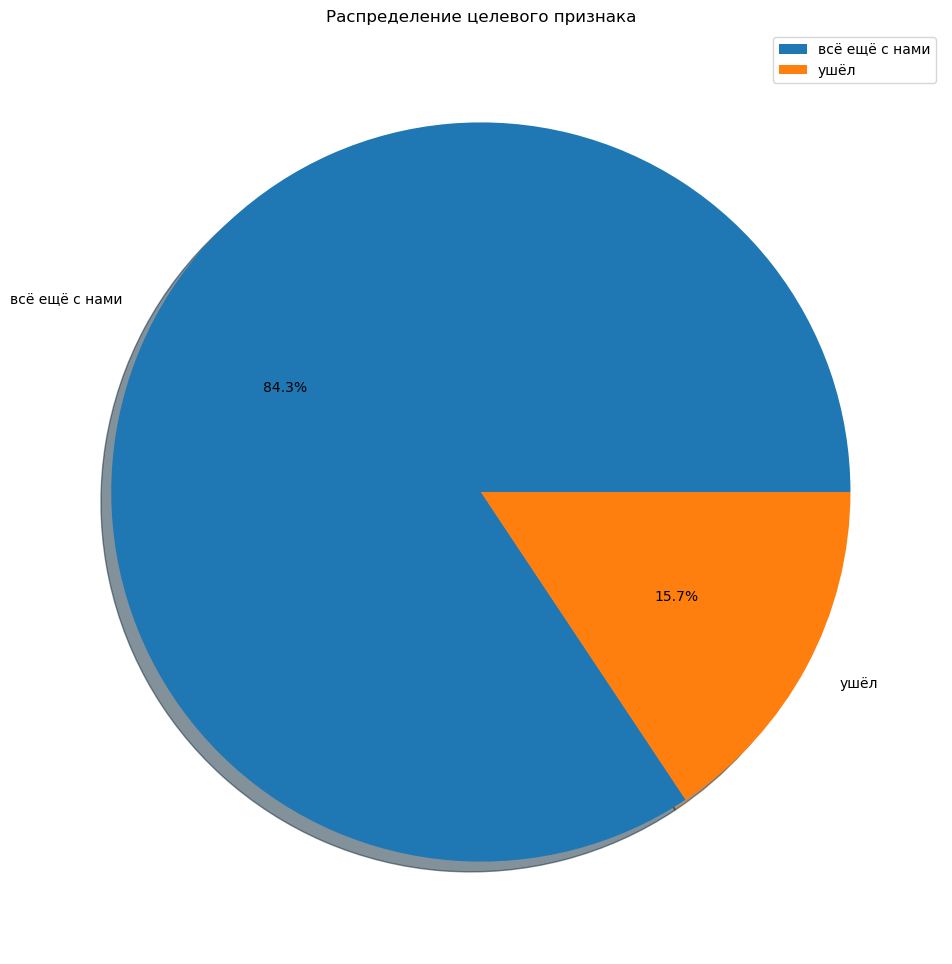

In [47]:
# Вычисляем количество значений 'всё ещё с нами' и 'ушёл' в столбце 'left_company'
value_counts = common_df['left_company'].value_counts()

# Создаем новую фигуру для графика с заданным размером
plt.figure(figsize=(12, 12))

# Создаем круговую диаграмму, указывая значения, метки, формат процентов, и добавляем тень
plt.pie(value_counts, labels=['всё ещё с нами', 'ушёл'], autopct='%1.1f%%', shadow=True)

# Добавляем легенду для круговой диаграммы с заданными метками
plt.legend(['всё ещё с нами', 'ушёл'])

# Задаем заголовок для графика
plt.title('Распределение целевого признака')

# Убираем оси координат, так как это круговая диаграмма
plt.axis('off')

# Отображаем график
plt.show()

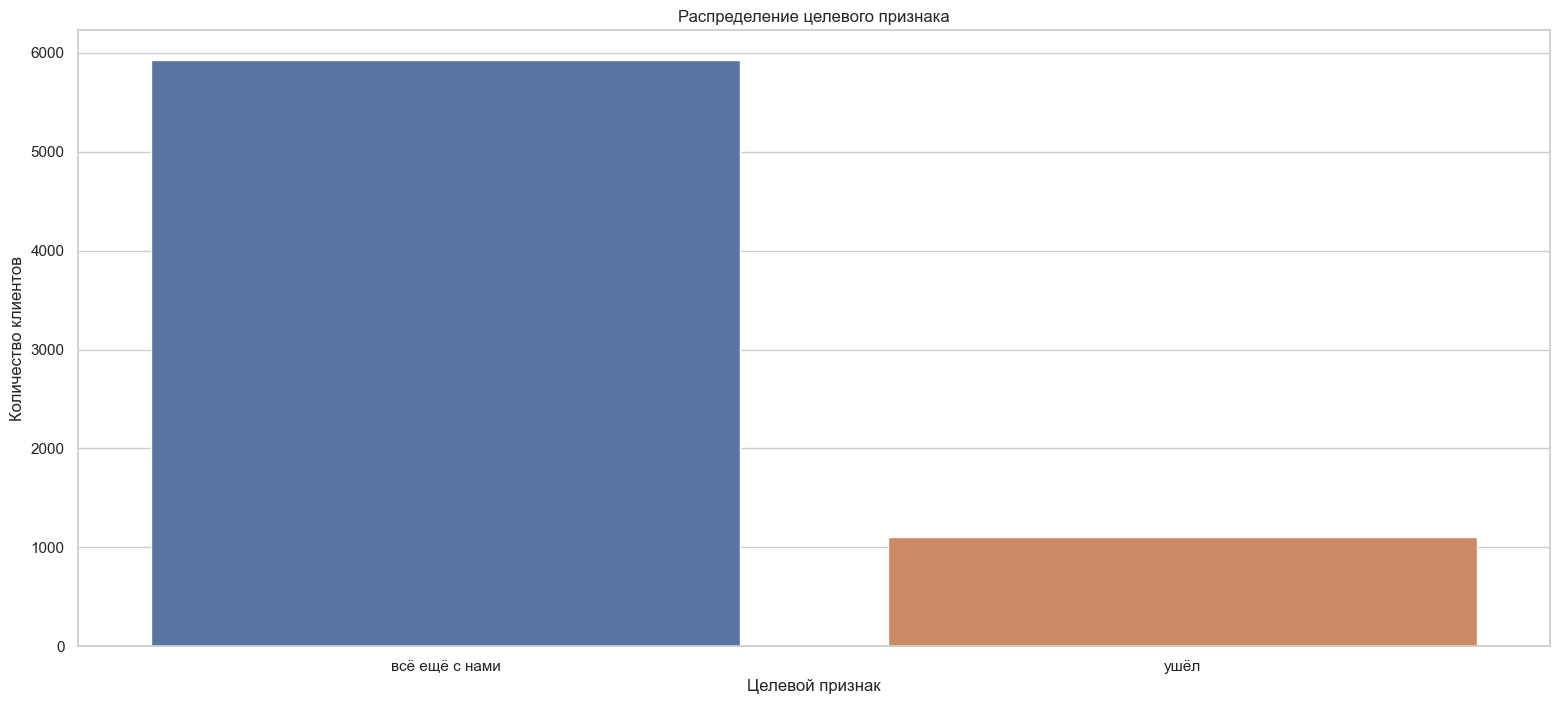

In [48]:
# Вычисляем количество значений 'всё ещё с нами' и 'ушёл' в столбце 'left_company'
value_counts = common_df['left_company'].value_counts()

# Создаем новую фигуру для графика с заданным размером
plt.figure(figsize=(19, 8))

# Устанавливаем стиль с сеткой для графика
sns.set(style='whitegrid')

# Создаем столбчатую диаграмму, указывая значения по x и y
sns.barplot(x=value_counts.index, y=value_counts.values)

# Задаем метки по оси x, чтобы они были 'всё ещё с нами' и 'ушёл'
plt.xticks(range(len(value_counts.index)), ['всё ещё с нами', 'ушёл'])

# Добавляем метку по оси x
plt.xlabel('Целевой признак')

# Добавляем метку по оси y
plt.ylabel('Количество клиентов')

# Задаем заголовок для графика
plt.title('Распределение целевого признака')

# Отображаем график
plt.show()

Данные графики демонстрируют, что за все время компанию покинуло приблизительно 16% (1101) от общего числа клиентов и в тоже время 84% (5931) все еще остаются с компанией. Это свидетельствует о том, что компания в целом имеет хороший уровень удержания клиентов, и большинство клиентов остаются с ней.

Давайте проанализируем количественные характеристики, создав парные графики, чтобы изучить взаимосвязи между ними.

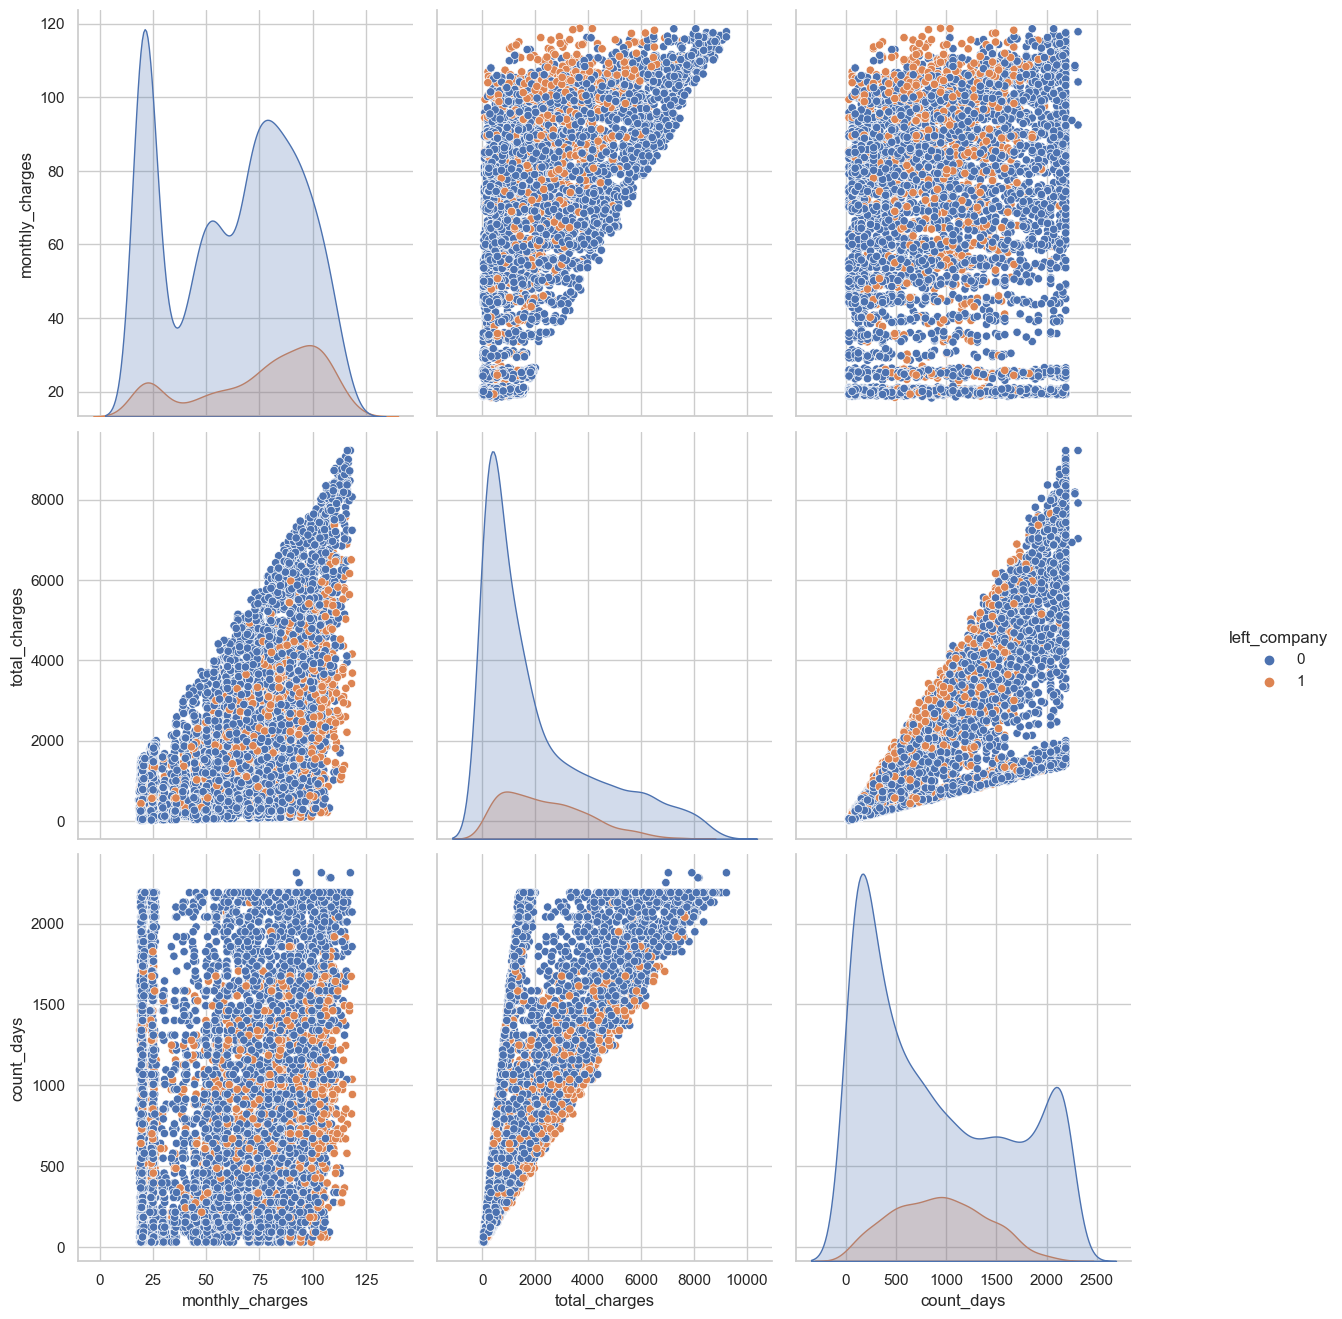

In [49]:
# Выбираем только необходимые столбцы для анализа
selected_columns = ['monthly_charges', 'total_charges', 'count_days', 'left_company']

# Создаем парный график с окраской по столбцу 'left_company' для выбранных столбцов
sns.pairplot(common_df[selected_columns], hue='left_company').fig.set_size_inches(14,14)

# Показываем парный график
plt.show()


Из графика видно, что клиенты уходят сравнительно быстро. Давайте проведем более детальный анализ этого явления.

In [50]:
# Вычисляем корреляцию между всеми числовыми столбцами DataFrame
df_contract.corr()

,paperless_billing,monthly_charges,total_charges,left_company,count_days
paperless_billing,1.000000,0.351930,0.152820,0.054492,-0.002913
monthly_charges,0.351930,1.000000,0.630297,0.153927,0.218955
total_charges,0.152820,0.630297,1.000000,0.051548,0.821442
left_company,0.054492,0.153927,0.051548,1.000000,0.015716
count_days,-0.002913,0.218955,0.821442,0.015716,1.000000


Из матрицы корреляции, можно сделать следующие выводы:

- `PaperlessBilling` и `MonthlyCharges` имеют положительную корреляцию в размере приблизительно `0.35`. Это может указывать на то, что клиенты, выбирающие беспапирную биллинговую систему, чаще всего имеют более высокие ежемесячные платежи.

- `MonthlyCharges` и `TotalCharges` также имеют положительную корреляцию, близкую к `0.63`. Это означает, что клиенты с более высокими ежемесячными платежами обычно имеют более высокие общие платежи за услуги.

- `TotalCharges` и `count_days` также сильно коррелируют, с коэффициентом корреляции около `0.82`. Это может свидетельствовать о том, что общие платежи с течением времени увеличиваются, возможно, по мере увеличения длительности контракта.

- `left_company` и `MonthlyCharges` имеют слабую положительную корреляцию около `0.15`. Это может означать, что более высокие ежемесячные платежи немного увеличивают вероятность того, что клиент покинет компанию, но связь не очень сильная.

- `left_company` и `TotalCharges` имеют также слабую положительную корреляцию около `0.05`. Это указывает на то, что общие платежи слабо связаны с решением клиента о покидании компании.

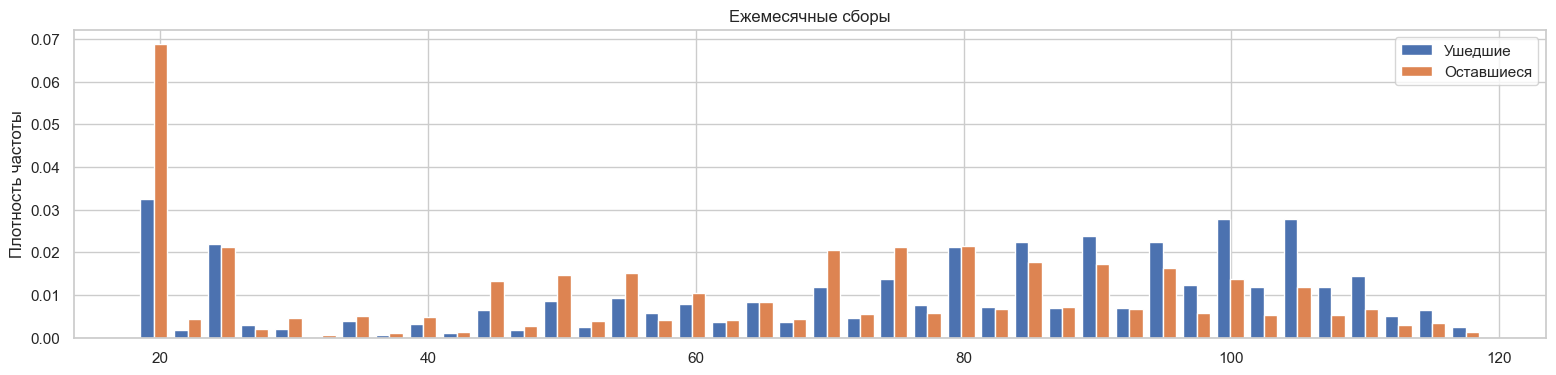

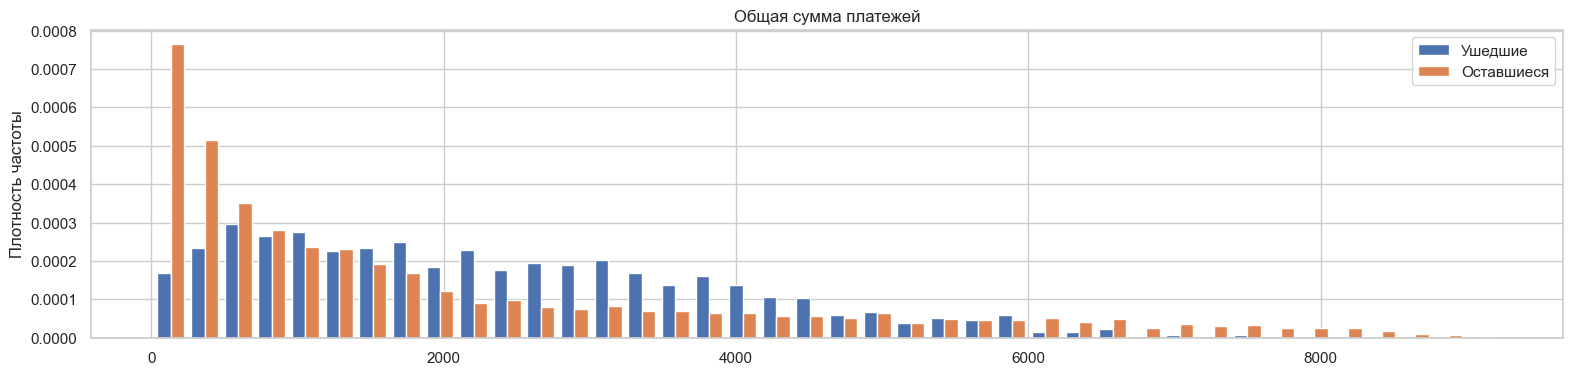

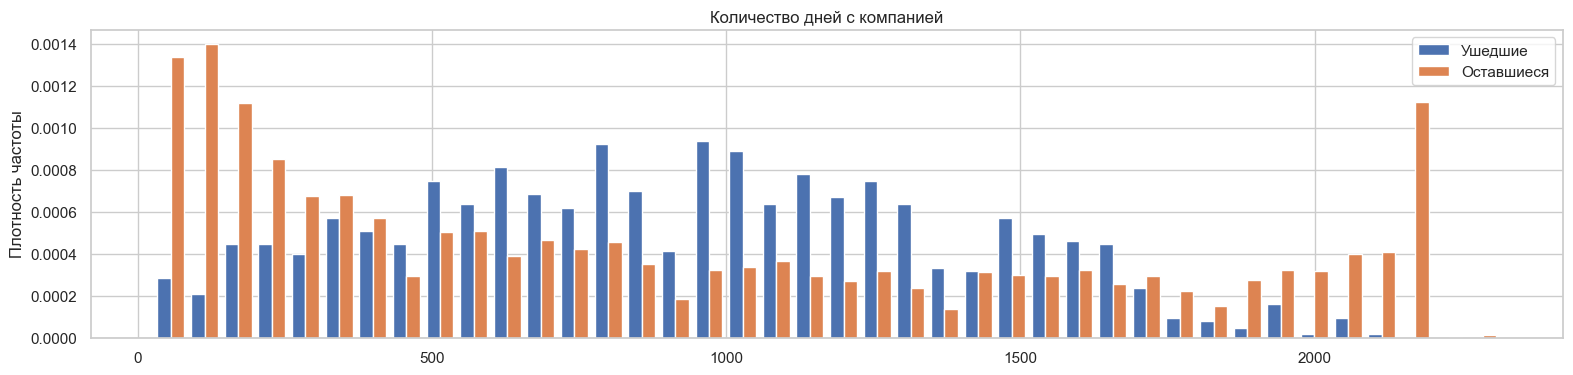

In [51]:
# Список количественных признаков, которые мы хотим отобразить
columns_to_plot = ['monthly_charges', 'total_charges', 'count_days']

# Русскоязычные названия для признаков
column_titles = {
    'monthly_charges': 'Ежемесячные сборы',
    'total_charges': 'Общая сумма платежей',
    'count_days': 'Количество дней с компанией',
}

# Итерируемся по выбранным признакам и строим гистограммы для каждого из них
for column in columns_to_plot:
    # Создаем новую фигуру для каждого признака
    plt.figure(figsize=(19, 4))
    
    # Строим гистограмму для клиентов, которые ушли (left_company == 1)
    # и для клиентов, которые остались (left_company == 0)
    plt.hist([common_df[common_df['left_company'] == 1][column], common_df[common_df['left_company'] == 0][column]], 
             label=['Ушедшие', 'Оставшиеся'], 
             density=True, 
             bins=40)
    
    # Добавляем легенду для различения групп
    plt.legend()
    
    # Устанавливаем заголовок графика с русскоязычным названием признака
    plt.title(column_titles[column])
    
    # Добавляем подпись к оси y
    plt.ylabel('Плотность частоты')
    
    # Отображаем график
    plt.show()


In [52]:
# Фильтруем данные для клиентов, которые ушли (left_company == 1) и выбираем столбец count_days
average_days_with_company = common_df[common_df['left_company'] == 1]['count_days'].mean()

# Выводим среднее количество дней с компанией
print(f"Среднее количество дней с компанией среди ушедших клиентов: {average_days_with_company:.2f} дней")


Среднее количество дней с компанией среди ушедших клиентов: 924.86 дней


**Вывод**

Среди клиентов, которые ушли:

- Средний ежемесячный платеж у большинства клиентов варьировался в диапазоне 60-110 у.е.
- Общая сумма платежей большинства клиентов составляла в среднем 2139 у.е.
- Среднее количество дней с компанией среди ушедших клиентов составило 925 дней и не превышало 2129 дней.

In [53]:
# Группируем данные по столбцу 'left_company' (ушли или остались клиенты)
# и для каждой группы вычисляем несколько агрегированных статистик для столбцов 'count_days' и 'monthly_charges'
common_df.groupby('left_company').agg({
    'count_days': ['min', 'max', 'mean', 'median'],  # Минимум, максимум, среднее и медианное значение 'count_days'
    'monthly_charges': ['min', 'max', 'mean', 'median']  # Минимум, максимум, среднее и медианное значение 'monthly_charges'
})

count_days                         monthly_charges          \
                    min   max       mean median             min     max   
left_company                                                              
0                    31  2314  895.33856  702.0           18.25  118.60   
1                    28  2129  924.86376  915.0           18.40  118.75   

                                
                   mean median  
left_company                    
0             62.803043  69.25  
1             75.546004  84.20

Получается, в среднем, клиенты проводили около 2,5 года с компанией, прежде чем уходить, и их средние месячные платежи были выше, чем у текущих клиентов. Следовательно, возможно, после массового оттока начались снижения цен. Давайте определим, когда это началось.

In [54]:
# Находим минимальную дату в столбце 'end_date'
common_df['end_date'].min()

Timestamp('2014-06-01 00:00:00')

In [55]:
# Фильтруем датасет, оставляем только ушедших клиентов, группируем по 'end_date' и считаем количество клиентов в каждой группе
churn_by_end_date = common_df.loc[common_df['left_company'] == 1].groupby('end_date').agg({'customer_id':'count'})

# Добавляем стилевое оформление с баровой визуализацией
churn_by_end_date.style.bar()

,customer_id
end_date,
2014-06-01 00:00:00,1
2014-09-01 00:00:00,2
2014-10-01 00:00:00,1
2014-11-01 00:00:00,1
2014-12-01 00:00:00,2
2015-01-01 00:00:00,5
2015-02-01 00:00:00,4
2015-03-01 00:00:00,3
2015-04-01 00:00:00,2


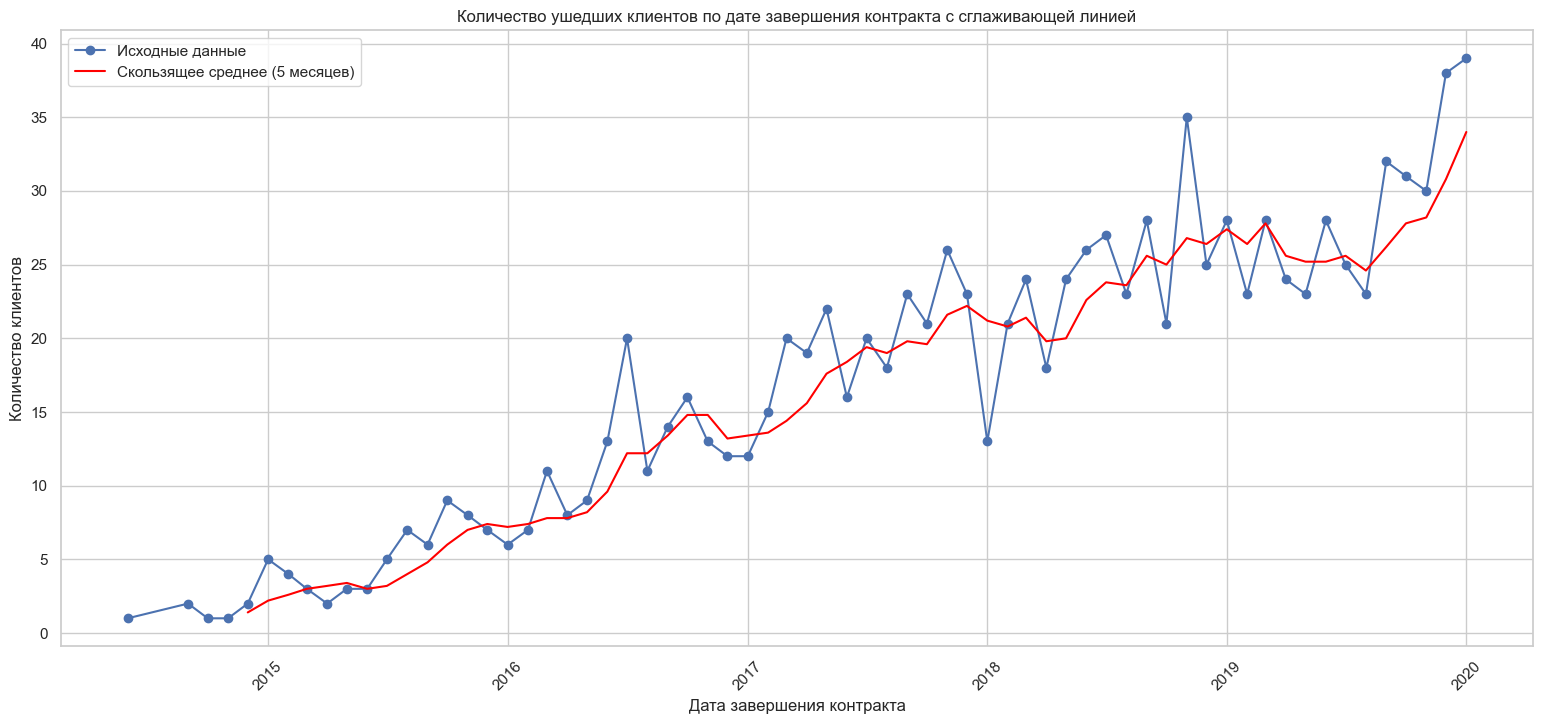

In [56]:
# Устанавливаем размер фигуры
plt.figure(figsize=(19, 8))

# Строим график, задаем стиль линии и маркеры для точек
plt.plot(churn_by_end_date.index, churn_by_end_date['customer_id'], marker='o', linestyle='-', label='Исходные данные')

# Вычисляем скользящее среднее с окном 5 месяцев
rolling_mean = churn_by_end_date['customer_id'].rolling(window=5).mean()

# Строим сглаживающую линию
plt.plot(churn_by_end_date.index, rolling_mean, linestyle='-', color='red', label='Скользящее среднее (5 месяцев)')

# Устанавливаем заголовок графика и подписи к осям
plt.title('Количество ушедших клиентов по дате завершения контракта с сглаживающей линией')
plt.xlabel('Дата завершения контракта')
plt.ylabel('Количество клиентов')

# Поворачиваем подписи по оси X для улучшения читаемости
plt.xticks(rotation=45)

# Включаем сетку на графике
plt.grid(True)

# Добавляем легенду
plt.legend()

# Отображаем график
plt.show()

Мы можем заметить, что уровень оттока клиентов постепенно рос из года в год. Тем не менее, выделяется отчетливая сезонность в увеличении оттока, которая наблюдается ближе к концу каждого года.

In [57]:
# Группируем данные по полу (столбец 'gender') и считаем количество клиентов (столбец 'customer_id') в каждой группе
gender_counts = common_df.loc[common_df['left_company'] == 1].groupby('gender').agg({'customer_id':'count'})

# Добавляем подписи к значениям пола
gender_counts.index = ['Мужчины', 'Женщины']

# Выводим результат
print(gender_counts)

         customer_id
Мужчины          528
Женщины          573


Исходя из полученных данных, можно сделать вывод, что среди ушедших клиентов количество женщин (573) превышает количество мужчин (528). Однако разница между количеством мужчин и женщин не является значительной, и пол клиента, скорее всего, не является определяющим фактором для ухода клиентов.

Объеденим оставшиеся выборки в одну посмотрим на кол-во пропусков.

In [58]:
# Объединяем данные из common_df, df_internet и df_phone по столбцу 'customer_id' с использованием левого объединения (how='left')
final_df = (common_df
            .merge(df_internet, on=['customer_id'], how='left')  # Объединяем с df_internet
            .merge(df_phone, on=['customer_id'], how='left')     # Затем объединяем с df_phone
           )

In [59]:
# Выводим информацию о DataFrame final_df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   int64         
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   left_company       7032 non-null   int64         
 9   count_days         7032 non-null   int64         
 10  gender             7032 non-null   int64         
 11  senior_citizen     7032 non-null   int64         
 12  partner            7032 non-null   int64         
 13  dependents         7032 non-null   int64         
 14  internet

Конечно, не все клиенты пользуются интернетом, не все используют телефонные услуги, и есть те, кто пользуется и тем, и другим. Давайте выделим эти группы клиентов и рассмотрим их отдельно.

In [60]:
# Создаем новый столбец 'type_service', в котором будем указывать тип услуг, используемых клиентами
# Сначала заполняем значение 'only_internet' для клиентов, у которых отсутствует информация об интернет-услугах
final_df.loc[final_df['internet_service'].isnull(), 'type_service'] = 'only_internet'

# Затем заполняем значение 'only_phone' для клиентов, у которых отсутствует информация о телефонных услугах
final_df.loc[final_df['multiple_lines'].isnull(), 'type_service'] = 'only_phone'

# Все остальные клиенты, у которых есть и информация об интернете, и о телефонных услугах, получат значение 'both types' (оба типа)
final_df['type_service'].fillna('both_types', inplace=True)

Проверим какие значения у нас остались пропущенными.

In [61]:
# Вызываем метод isna() для DataFrame final_df, который возвращает булеву маску, где True - это пропущенные значения, False - не пропущенные.
# Затем вызываем метод sum() для каждого столбца, который суммирует True значения (количество пропущенных значений) по каждому столбцу.
missing_values = final_df.isna().sum()

# Результат будет представлен в виде Series, где индексы - это названия столбцов, а значения - количество пропущенных значений в каждом столбце.
# Вы можете вывести этот Series на экран для просмотра количества пропущенных значений в каждом столбце.
print(missing_values)

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
left_company            0
count_days              0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
multiple_lines        680
type_service            0
dtype: int64


Посмотрим на данные где есть пропуски.

In [62]:
# Используем фильтрацию для выбора строк, в которых столбец 'internet_service' имеет пропущенные значения (NaN).
# Мы используем метод isna() для проверки на пропущенные значения и возвращаем булеву маску, которая равна True для строк с пропущенными значениями в 'internet_service'.
# Затем мы применяем эту маску к DataFrame final_df.
final_df[final_df['internet_service'].isna()].head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left_company,count_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,type_service
11,7469-LKBCI,2018-10-01,2020-02-01,Two year,0,Credit card (automatic),18.95,312.30,0,488,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,only_internet
16,8191-XWSZG,2015-10-01,2020-02-01,One year,0,Mailed check,20.65,1106.01,0,1584,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,only_internet
21,1680-VDCWW,2019-02-01,2020-02-01,One year,0,Bank transfer (automatic),19.80,237.60,0,365,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,only_internet


In [63]:
# Используем фильтрацию для выбора строк, в которых столбец 'multiple_lines' имеет пропущенные значения (NaN).
# Мы используем метод isna() для проверки на пропущенные значения и возвращаем булеву маску, которая равна True для строк с пропущенными значениями в 'multiple_lines'.
# Затем мы применяем эту маску к DataFrame final_df.
final_df[final_df['multiple_lines'].isna()].head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,left_company,count_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,type_service
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,31.04,0,31,0,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN,only_phone
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1960.60,0,1371,1,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN,only_phone
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,0,Mailed check,29.75,300.48,0,306,0,0,0,0,DSL,1.0,0.0,0.0,0.0,0.0,0.0,NaN,only_phone


Посмотрим какие значения присутствуют в столбцах где есть пропуски

In [64]:
# Создаем список 'columns_with_missing_values', содержащий имена столбцов, в которых есть пропущенные значения
columns_with_missing_values = final_df.columns[final_df.isna().any()].tolist()

# Для каждого столбца с пропущенными значениями
for column in columns_with_missing_values:
    # Получаем уникальные значения в данном столбце
    unique_values = final_df[column].unique()
    
    # Выводим уникальные значения на экран с указанием имени столбца
    print(f"Уникальные значения в столбце '{column}': {unique_values}")

Уникальные значения в столбце 'internet_service': ['DSL' 'Fiber optic' nan]
Уникальные значения в столбце 'online_security': [ 0.  1. nan]
Уникальные значения в столбце 'online_backup': [ 1.  0. nan]
Уникальные значения в столбце 'device_protection': [ 0.  1. nan]
Уникальные значения в столбце 'tech_support': [ 0.  1. nan]
Уникальные значения в столбце 'streaming_tv': [ 0.  1. nan]
Уникальные значения в столбце 'streaming_movies': [ 0.  1. nan]
Уникальные значения в столбце 'multiple_lines': [nan  0.  1.]


Проверим распределение данных значений

In [65]:
# Создаем список столбцов с пропущенными значениями
columns_with_missing_values = final_df.columns[final_df.isna().any()].tolist()

# Для каждого столбца с пропусками выводим распределение значений
for column in columns_with_missing_values:
    # Выводим заголовок
    print(f"Распределение значений в столбце '{column}':")
    
    # Выводим распределение значений в столбце, считая количество каждого уникального значения
    print(final_df[column].value_counts())
    
    # Выводим пустую строку для разделения между столбцами
    print()

Распределение значений в столбце 'internet_service':
Fiber optic    3096
DSL            2416
Name: internet_service, dtype: int64

Распределение значений в столбце 'online_security':
0.0    3497
1.0    2015
Name: online_security, dtype: int64

Распределение значений в столбце 'online_backup':
0.0    3087
1.0    2425
Name: online_backup, dtype: int64

Распределение значений в столбце 'device_protection':
0.0    3094
1.0    2418
Name: device_protection, dtype: int64

Распределение значений в столбце 'tech_support':
0.0    3472
1.0    2040
Name: tech_support, dtype: int64

Распределение значений в столбце 'streaming_tv':
0.0    2809
1.0    2703
Name: streaming_tv, dtype: int64

Распределение значений в столбце 'streaming_movies':
0.0    2781
1.0    2731
Name: streaming_movies, dtype: int64

Распределение значений в столбце 'multiple_lines':
0.0    3385
1.0    2967
Name: multiple_lines, dtype: int64



Посмотрим как распределены пропуски по датам заключения контракта.

In [66]:
# Выбираем даты с пропущенными значениями
dates_with_missing_values = final_df.loc[final_df.isna().any(axis=1), 'begin_date']

# Получаем уникальные даты
unique_dates_with_missing_values, counts = np.unique(dates_with_missing_values, return_counts=True)

# Создаем DataFrame для уникальных дат и их количества пропущенных значений
unique_dates_df = pd.DataFrame({'Date': unique_dates_with_missing_values, 'Missing Values Count': counts})

# Сортируем DataFrame по датам
unique_dates_df = unique_dates_df.sort_values(by='Date')

# Выводим на экран
unique_dates_df

,Date,Missing Values Count
0,2014-01-01,1
1,2014-02-01,97
2,2014-03-01,53
3,2014-04-01,33
4,2014-05-01,33
...,...,...
68,2019-09-01,59
69,2019-10-01,79
70,2019-11-01,84
71,2019-12-01,73


Исходя из уникальных значений и распределения данных в столбцах, можно принять следующие решения по заполнению пропусков:

1. **internet_service**: Столбец `'internet_service'` представляет тип интернет-соединения. Так как у нас нет информации о том, какое интернет-соединение было у клиентов с пропущенными значениями, мы можем заполнить пропуски значением `'Unknown'` или `'No Internet'` (нет интернета), в зависимости от контекста данных. Это позволит сохранить информацию о том, что у этих клиентов нет интернет-соединения.

2. Остальные столбцы (**online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines**): Эти столбцы представляют наличие или отсутствие определенных услуг (0 - нет, 1 - есть). Поскольку у нас нет информации о наличии или отсутствии услуг у клиентов с пропущенными значениями, мы также можем заполнить пропуски значением `'Unknown'` или `'No Service'` (нет услуги), в зависимости от контекста данных. Это позволит сохранить информацию о том, что у этих клиентов нет указанных услуг.

Итак, предлагается заполнить пропуски во всех категориальных столбцах значениями `'Unknown'`.

In [67]:
# Заполняем все пропущенные значения в датафрейме final_df значением "Unknown"
final_df.fillna("Unknown", inplace=True)

Проверим результат заполнения

In [68]:
# Вызываем метод isna() для DataFrame final_df, который возвращает булеву маску, где True - это пропущенные значения, False - не пропущенные.
# Затем вызываем метод sum() для каждого столбца, который суммирует True значения (количество пропущенных значений) по каждому столбцу.
missing_values = final_df.isna().sum()

# Результат будет представлен в виде Series, где индексы - это названия столбцов, а значения - количество пропущенных значений в каждом столбце.
# Вы можете вывести этот Series на экран для просмотра количества пропущенных значений в каждом столбце.
print(missing_values)

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
left_company         0
count_days           0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
type_service         0
dtype: int64


Мы разделим клиентов на две группы: тех, кто ушёл, и тех, кто остался. Затем создадим функцию для построения диаграммы распределения различных услуг для каждой из этих групп клиентов.

In [69]:
# Отбираем клиентов, которые ушли
left = final_df.loc[final_df['left_company'] == 1]

# Отбираем клиентов, которые остались
no_left = final_df.loc[final_df['left_company'] == 0]

In [70]:
def diagramma(df, how_groupby, title):
    # Группируем данные по заданному признаку и считаем количество клиентов в каждой группе
    grouped_data = df.groupby(how_groupby).agg({'customer_id': 'count'})
    
    # Создаем новую фигуру для графика
    plt.figure(figsize=(19, 12))
    
    # Строим круговую диаграмму с процентным отображением и тенью
    plt.pie(grouped_data['customer_id'], labels=grouped_data.index, autopct='%1.1f%%', shadow=True)
    
    # Устанавливаем заголовок для диаграммы
    plt.title(title)
    
    # Устанавливаем равное соотношение осей для круговой диаграммы
    plt.axis('equal')
    
    # Отображаем диаграмму
    plt.show()

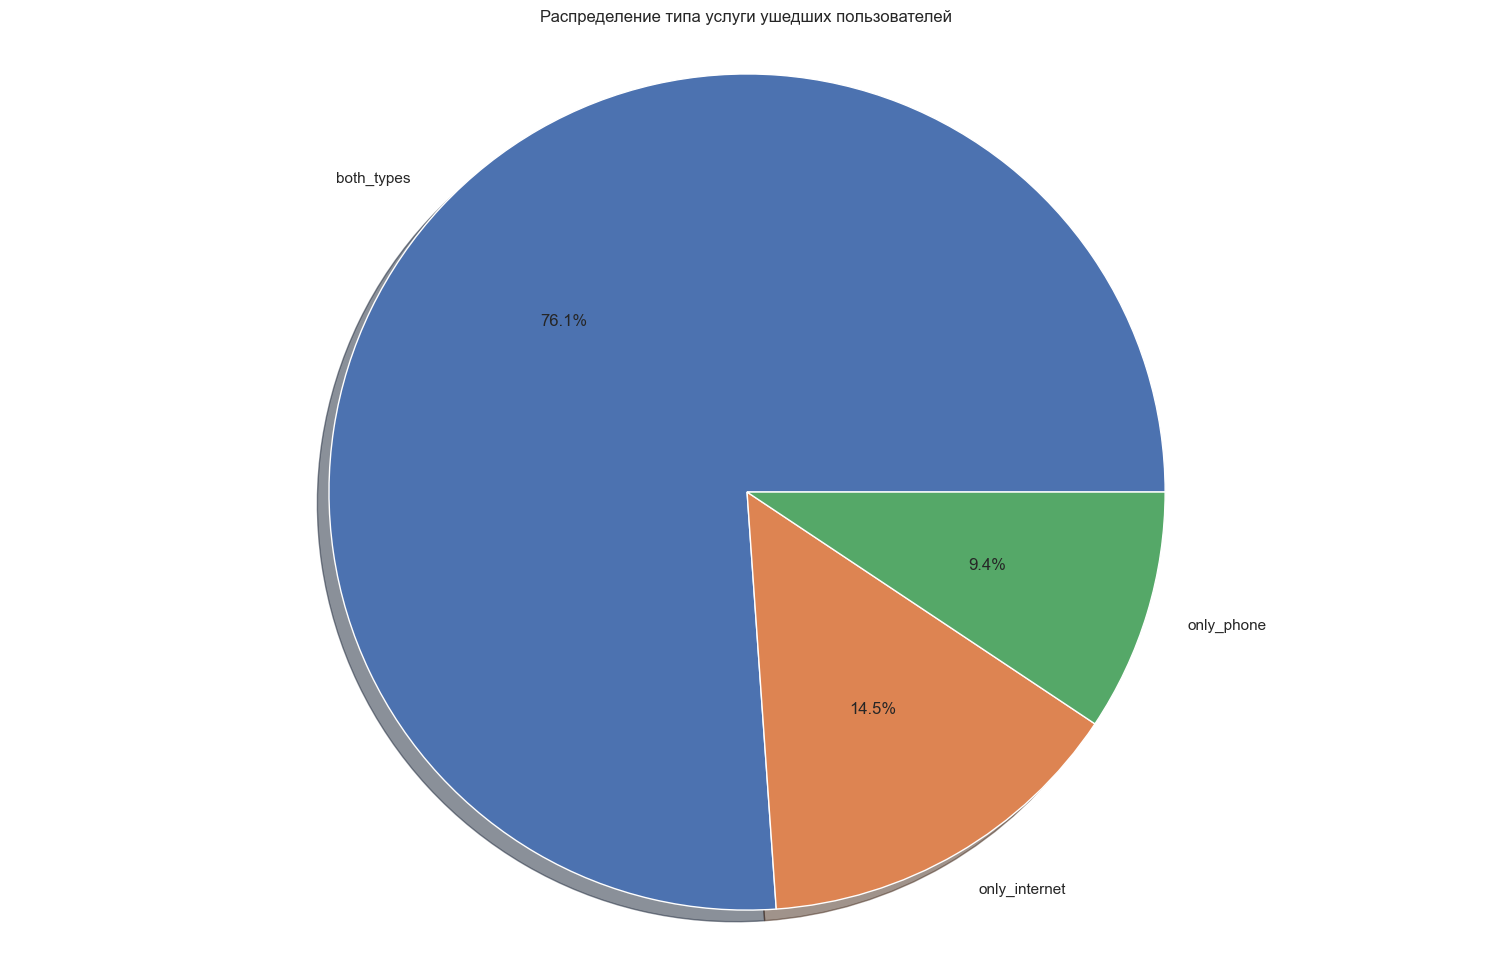

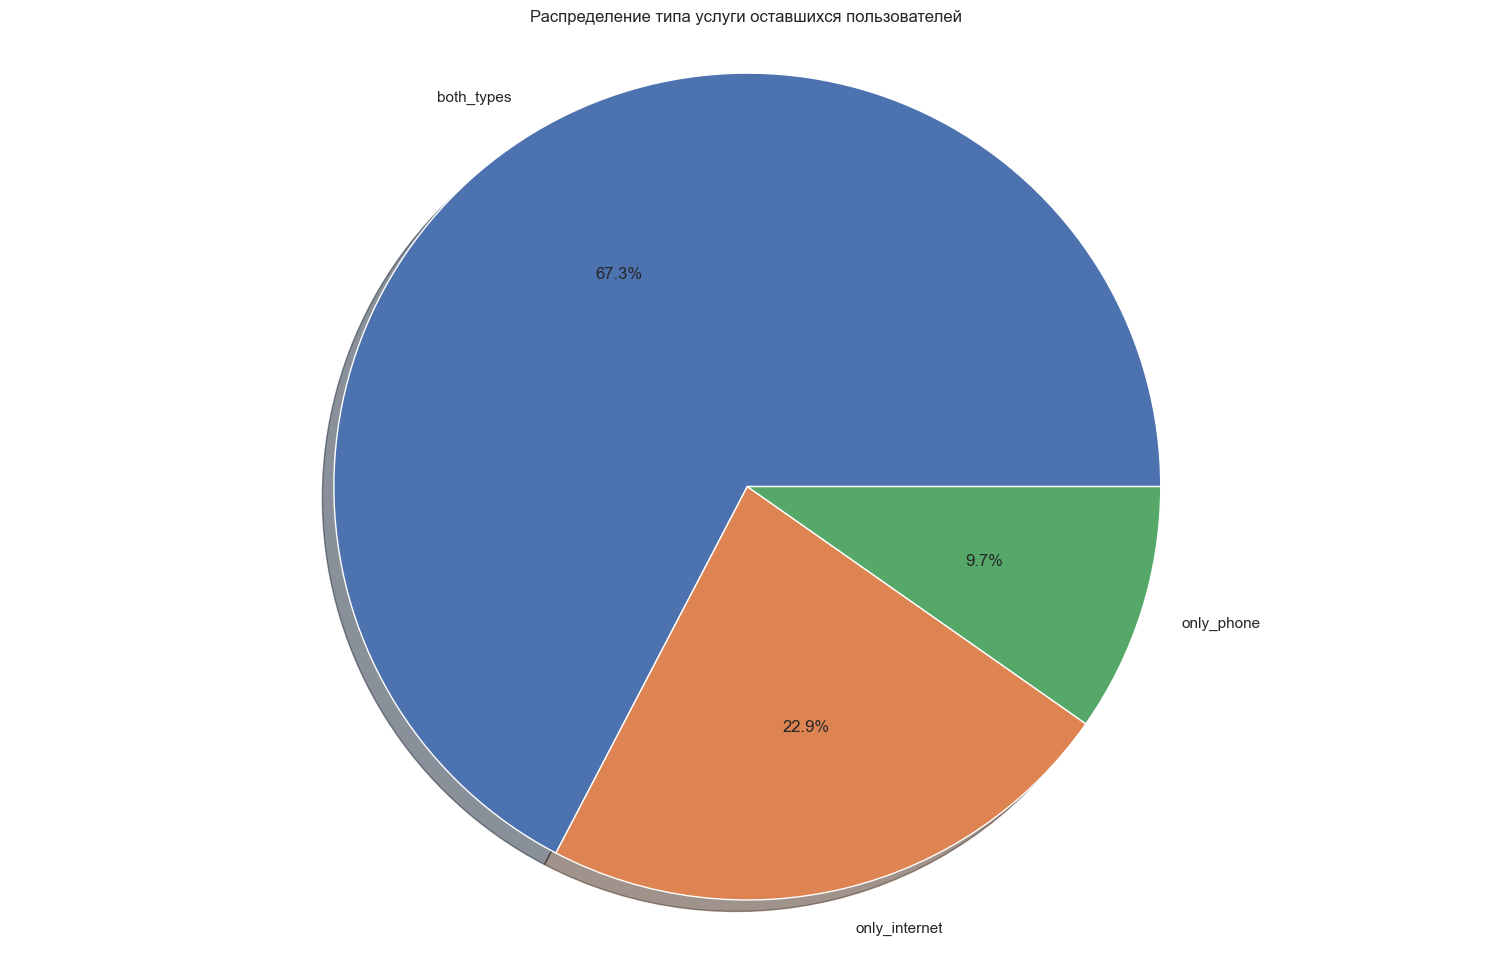

In [71]:
# Строим диаграмму распределения типа услуги ушедших пользователей
diagramma(left, 'type_service', 'Распределение типа услуги ушедших пользователей')

# Строим диаграмму распределения типа услуги оставшихся пользователей
diagramma(no_left, 'type_service', 'Распределение типа услуги оставшихся пользователей')

Да, судя по данным, клиенты, использующие обе услуги (интернет и телефон), склонны чаще уходить. Давайте теперь рассмотрим влияние типа подписки.

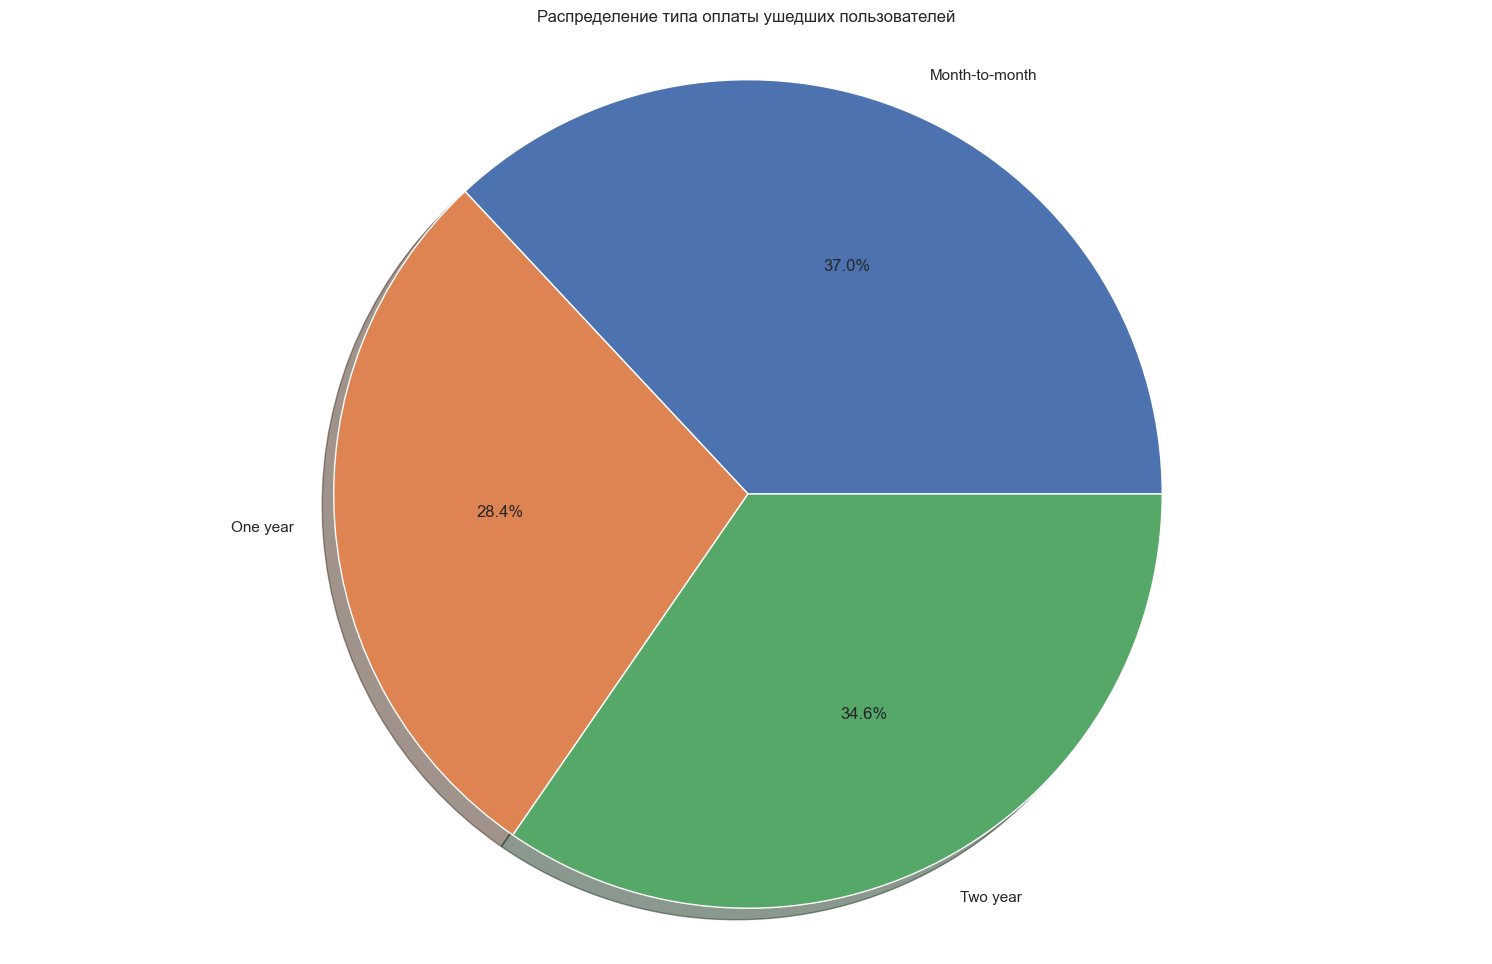

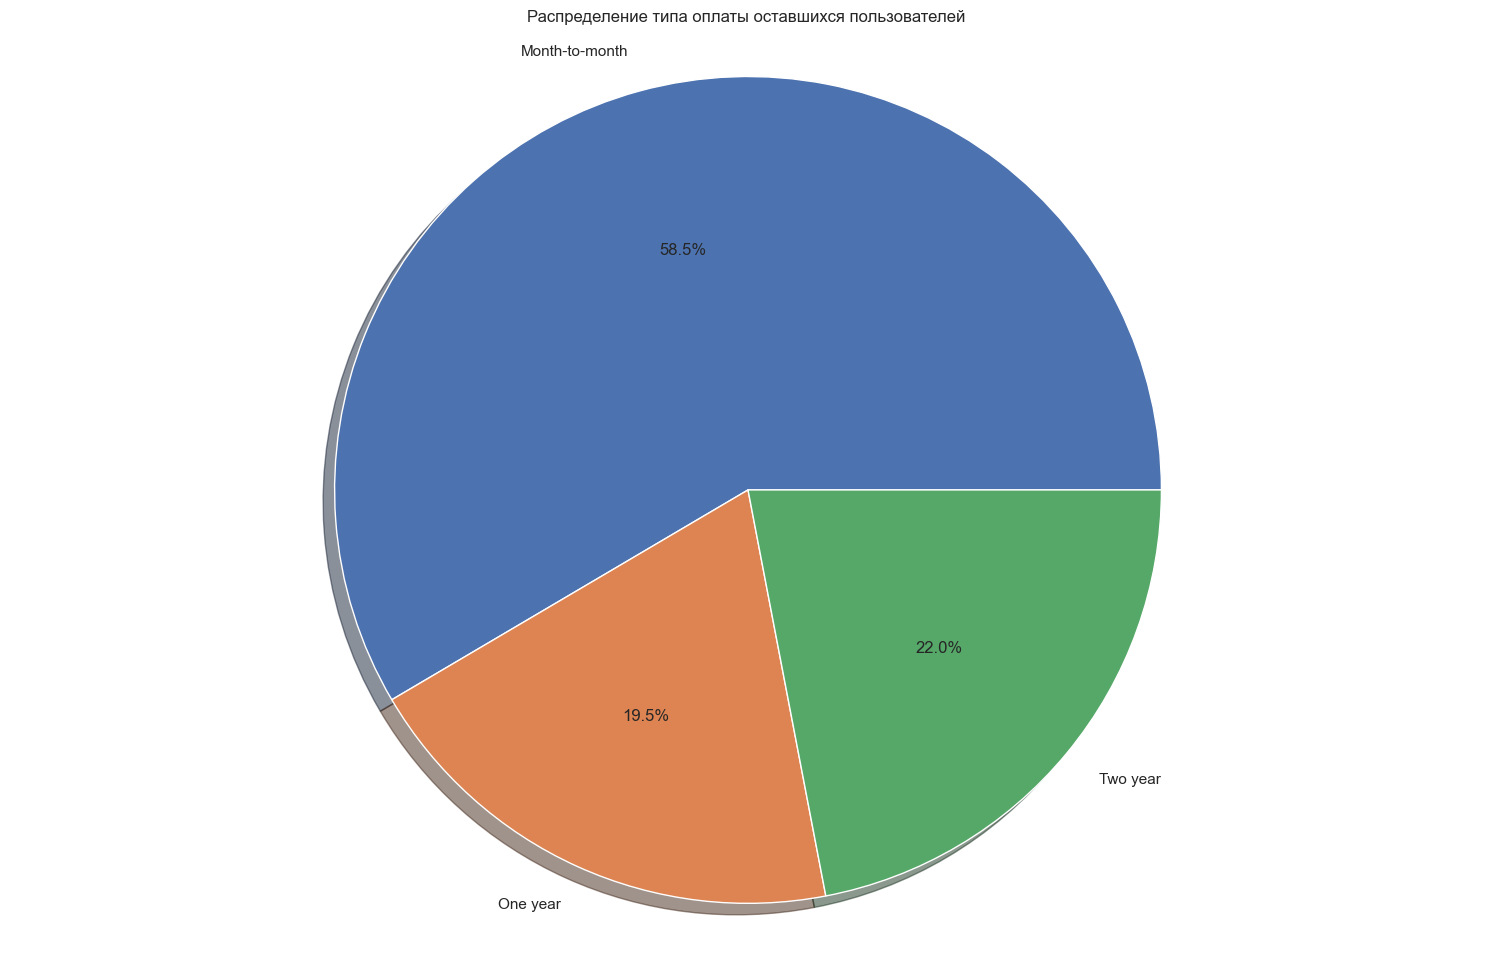

In [72]:
# Строим диаграмму для ушедших пользователей
diagramma(left, 'type', 'Распределение типа оплаты ушедших пользователей')
# Строим диаграмму для оставшихся пользователей
diagramma(no_left, 'type', 'Распределение типа оплаты оставшихся пользователей')

Мы видим, что клиенты, которые платят ежемесячно, чаще всего решают уходить. Мы также обратили внимание, что средняя ежемесячная оплата у тех, кто ушел, значительно выше. В свете этой информации, возможно, стоит рассмотреть предложение скидок клиентам, которые пользуются ежемесячной оплатой, чтобы удержать их и снизить отток клиентов.

**Удаление избыточных столбцов**

Для модели будут избыточными колонки с датами `begin_date` и `end_date`, поэтому удалим их из финального датасета. Уникальный идентификатор пользователя `customer_id` уже не несет смысловой нагрузки на данном этапе проекта и его тоже уберем. Теперь подготовим данные для обучения модели и посмотрим на мультиколлинеарность признаков.

In [73]:
# Удаляем столбцы 'begin_date', 'end_date', 'customer_id' из финального датасета
final_data = final_df.drop(columns=['begin_date', 'end_date', 'customer_id'])

# Преобразуем столбец 'dependents' в тип данных 'object'
final_data['dependents'] = final_data['dependents'].astype('object')
# Преобразуем столбец 'partner' в тип данных 'object'
final_data['partner'] = final_data['partner'].astype('object')
# Преобразуем столбец 'senior_citizen' в тип данных 'object'
final_data['senior_citizen'] = final_data['senior_citizen'].astype('object')
# Преобразуем столбец 'gender' в тип данных 'object'
final_data['gender'] = final_data['gender'].astype('object')
# Преобразуем столбец 'paperless_billing' в тип данных 'object'
final_data['paperless_billing'] = final_data['paperless_billing'].astype('object')
# Выводим информацию о DataFrame, чтобы проверить, что колонки удалены корректно
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   left_company       7032 non-null   int64  
 6   count_days         7032 non-null   int64  
 7   gender             7032 non-null   object 
 8   senior_citizen     7032 non-null   object 
 9   partner            7032 non-null   object 
 10  dependents         7032 non-null   object 
 11  internet_service   7032 non-null   object 
 12  online_security    7032 non-null   object 
 13  online_backup      7032 non-null   object 
 14  device_protection  7032 non-null   object 
 15  tech_support       7032 non-null   object 
 16  streaming_tv       7032 

**Проверка данных на мультиколлинеарность**

Посторим матрицу корреляции для числовых и категоральных признаков.

In [74]:
# Создаем матрицу корреляции Phi-K (PHIK) для интервальных столбцов 'monthly_charges', 'total_charges', 'left_company' и 'count_days'
phik_overview = final_data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'left_company', 'count_days'])

# Округляем значения в матрице корреляции до двух знаков после запятой
phik_overview.round(2)

,type,paperless_billing,payment_method,monthly_charges,total_charges,left_company,count_days,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,type_service
type,1.00,0.11,0.28,0.39,0.47,0.09,0.64,0.00,0.09,0.18,0.15,0.50,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.45
paperless_billing,0.11,1.00,0.37,0.47,0.20,0.08,0.02,0.00,0.24,0.01,0.17,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.20
payment_method,0.28,0.37,1.00,0.40,0.33,0.21,0.35,0.00,0.29,0.24,0.22,0.32,0.31,0.29,0.30,0.32,0.28,0.28,0.17,0.27
monthly_charges,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.01,0.30,0.20,0.18,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.89
total_charges,0.47,0.20,0.33,0.71,1.00,0.30,0.85,0.00,0.14,0.38,0.09,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.47
left_company,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.01,0.09,0.23,0.05,0.06,0.06,0.09,0.09,0.05,0.08,0.09,0.11,0.04
count_days,0.64,0.02,0.35,0.39,0.85,0.37,1.00,0.00,0.07,0.45,0.20,0.06,0.35,0.37,0.38,0.35,0.31,0.31,0.35,0.03
gender,0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
senior_citizen,0.09,0.24,0.29,0.30,0.14,0.09,0.07,0.00,1.00,0.02,0.32,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.11
partner,0.18,0.01,0.24,0.20,0.38,0.23,0.45,0.00,0.02,1.00,0.65,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.00


Исходя из матрицы корреляции, можно сделать следующие выводы:

- Из данной матрицы корреляции видно, что многие признаки имеют достаточно высокую корреляцию между собой. Например, есть сильная положительная корреляция (близкая к 1) между признаками `monthly_charges`, `total_charges`, `streaming_tv`, `streaming_movies`, `device_protection`, `online_backup`, `online_security`, `tech_support`, `internet_service`. Это может указывать на то, что эти признаки взаимосвязаны и изменения в одном из них могут сильно влиять на другие.

- Также видно, что признаки `left_company` и `count_days` имеют относительно высокую корреляцию (`0,37`), что может указывать на влияние времени, проведенного клиентом с компанией, на решение о его уходе.

- С другой стороны, признаки `gender`, `paperless_billing`, `payment_method`, `type`, `partner`, `dependents` имеют низкую корреляцию между собой и с другими признаками, что может означать их независимость от остальных признаков.

**Построим тепловую карту корреляции**

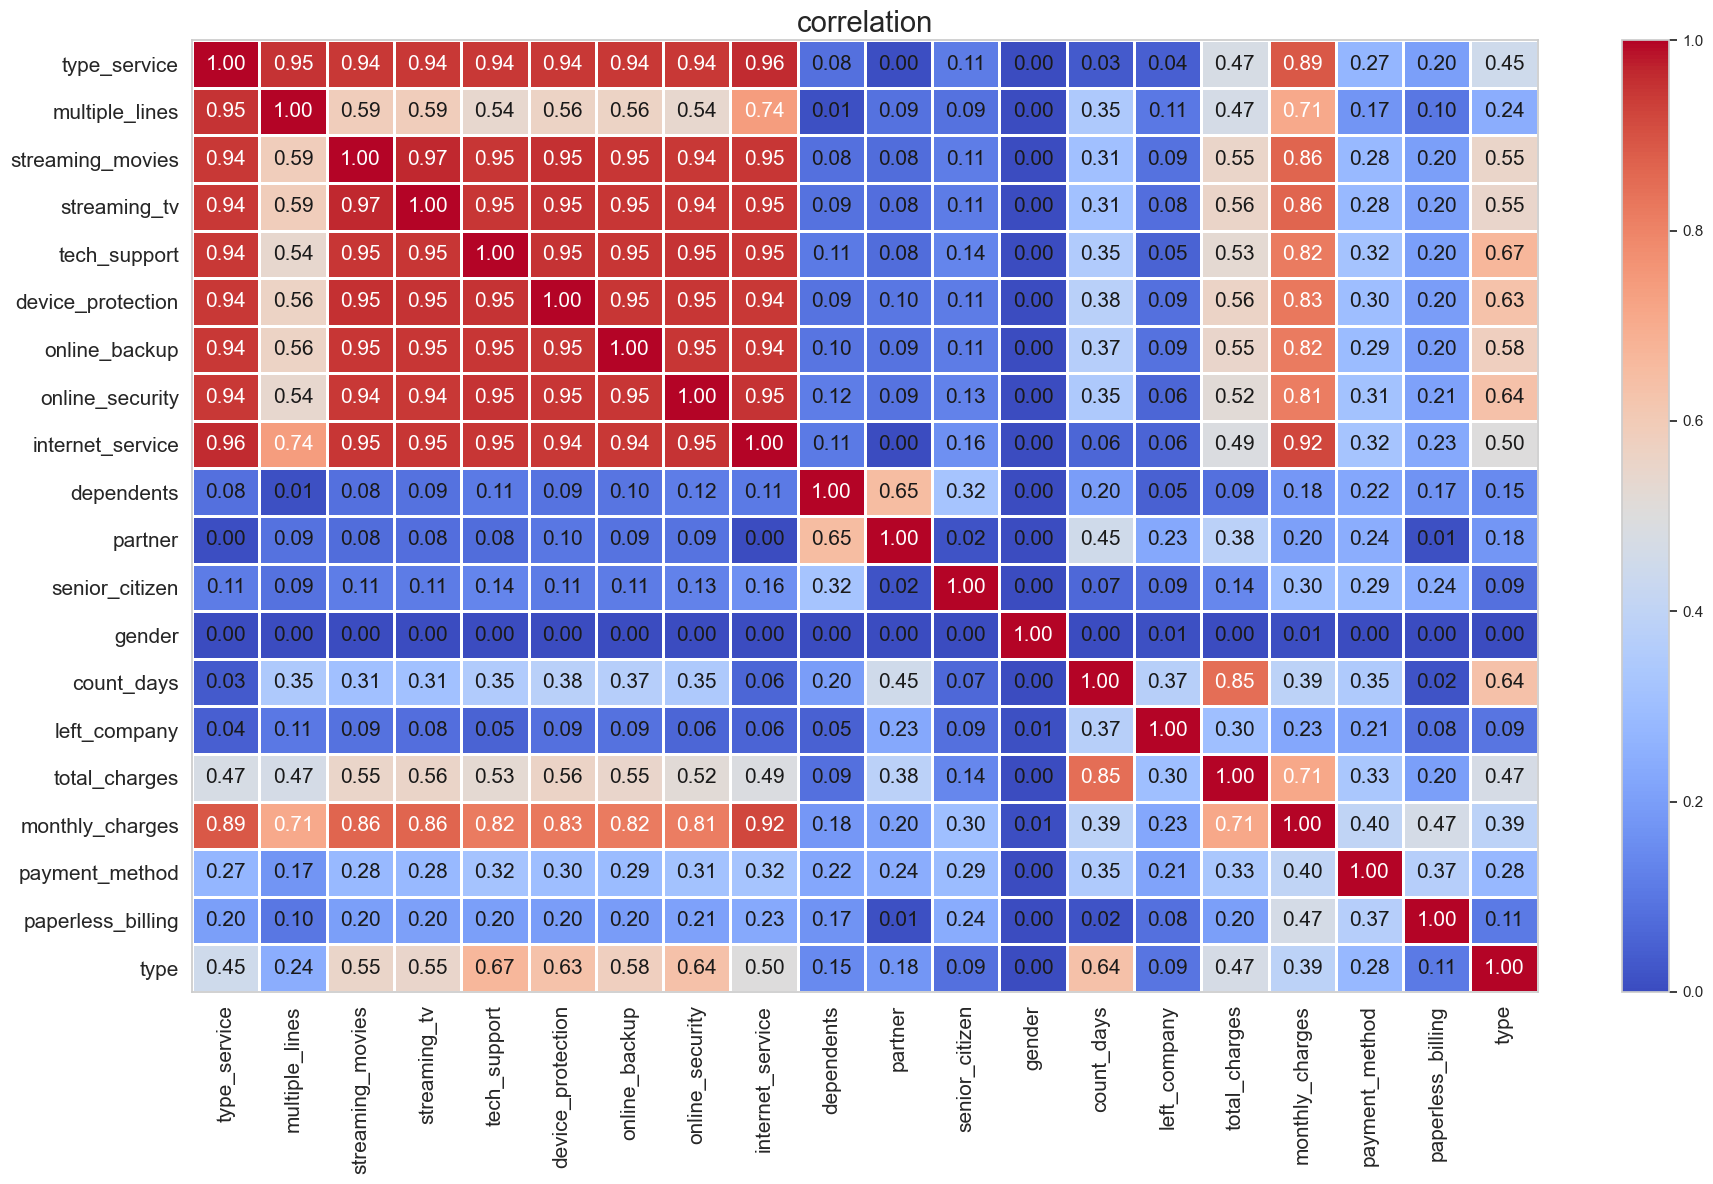

In [75]:
# Отображаем корреляционную матрицу с использованием plot_correlation_matrix
plot_correlation_matrix(
    phik_overview.values,              # Матрица корреляции Phi-K (PHIK) в виде массива значений
    x_labels=phik_overview.columns,    # Задаем подписи по горизонтали (столбцы)
    y_labels=phik_overview.index,      # Задаем подписи по вертикали (индексы)
    vmin=0,                            # Минимальное значение для цветовой карты
    vmax=1,                            # Максимальное значение для цветовой карты
    color_map="coolwarm",              # Выбираем цветовую карту
    title="correlation",               # Заголовок графика
    fontsize_factor=1.5,               # Множитель размера шрифта
    figsize=(19, 12)                   # Размер графика (ширина x высота)
)

# Устанавливаем плотное расположение графика
plt.tight_layout()

Итак, после анализа матрицы корреляции видно, что некоторые интернет-услуги, такие как `streaming_tv` и `streaming_movies` (0,97) и т.д., сильно коррелируют друг с другом, что может указывать на то, что их часто подключают вместе. Это может свидетельствовать о том, что эти услуги предлагаются клиентам в виде пакета.

Также мы видим, что столбец `total_charges` сильно коррелирует с признаком `count_days` (количеством дней с компанией), что логично, так как чем дольше клиенты находятся с компанией тем больше компания зарабатывает на них. Для уменьшения размерности и избежания мультиколлинеарности, можно рассмотреть удаление `total_charges`, так как он имеет наименьшую корреляцию с другими признаками и может быть в некоторой степени избыточным.

TotalCharges можем смело убирать

In [76]:
# Удаляем столбец 'total_charges' с помощью метода drop
# axis=1 указывает, что мы удаляем столбец, inplace=True означает, что изменение делается в исходном DataFrame
final_data.drop(['total_charges'], axis=1, inplace=True)

# Обучение модели

Для начала мы уберем ненужные признаки и преобразуем оставшиеся в категориальные. Затем разделим нашу выборку на обучающую (75%) и тестовую (25%) подвыборки.

In [77]:
# Разделяем данные на обучающую и тестовую выборки
# Для признаков исключаем столбец 'left_company', а для целевой переменной оставляем только его
features_train, features_test, target_train, target_test = train_test_split(
    final_data.drop(['left_company'], axis=1),  # Признаки (исключаем столбец 'left_company')
    final_data.left_company,  # Целевая переменная (оставляем только столбец 'left_company')
    test_size=0.25,  # Доля тестовой выборки (25%)
    random_state=RANDOM_STATE,  # Задаем случайное состояние для воспроизводимости
    stratify=final_data.left_company  # Стратификация по целевой переменной для сохранения баланса классов
)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5274, 18)
(1758, 18)
(5274,)
(1758,)


In [78]:
# Выбираем все столбцы с типом данных object (строковые столбцы) как категориальные
cat_list = final_data.select_dtypes(include=['object']).columns.tolist()

**one-hot кодирование**

In [79]:
# Применяем метод pd.get_dummies() для создания фиктивных (dummy) переменных для категориальных столбцов в features_train.
# Мы используем drop_first=True, чтобы избежать ловушки фиктивных переменных (одну из категорий кодируем 0, если остальные 0).
dummy_variables = pd.get_dummies(features_train[cat_list], drop_first=True)

# Присоединяем полученные фиктивные переменные к исходному DataFrame features_train с помощью метода .join().
features_train = features_train.join(dummy_variables)

# Удаляем категориальные столбцы из набора данных обучения (features_train)
features_train.drop(cat_list, axis=1, inplace=True)

# Выводим первые 5 строк обновленного DataFrame, чтобы проверить результат.
features_train.head(5)

,monthly_charges,count_days,type_One year,type_Two year,paperless_billing_1,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_1,senior_citizen_1,partner_1,dependents_1,internet_service_Fiber optic,internet_service_Unknown,online_security_1.0,online_security_Unknown,online_backup_1.0,online_backup_Unknown,device_protection_1.0,device_protection_Unknown,tech_support_1.0,tech_support_Unknown,streaming_tv_1.0,streaming_tv_Unknown,streaming_movies_1.0,streaming_movies_Unknown,multiple_lines_1.0,multiple_lines_Unknown,type_service_only_internet,type_service_only_phone
4847,104.05,1949,0,1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0
2777,85.40,1157,0,1,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0
1239,45.30,153,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
238,95.00,427,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
3143,75.45,1432,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
# # Выбираем столбцы с категориальными переменными из тестового набора данных
# cat_list = features_test.select_dtypes(include=['object']).columns.tolist()

# Создаем фиктивные (dummy) переменные для категориальных столбцов и удаляем первую фиктивную переменную (drop_first=True)
features_test = features_test.join(pd.get_dummies(features_test[cat_list], drop_first=True))

# Удаляем категориальные столбцы из набора данных тестирования (features_test)
features_test.drop(cat_list, axis=1, inplace=True)

# Выводим первые 5 строк обновленного тестового набора данных
features_test.head(5)

,monthly_charges,count_days,type_One year,type_Two year,paperless_billing_1,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_1,senior_citizen_1,partner_1,dependents_1,internet_service_Fiber optic,internet_service_Unknown,online_security_1.0,online_security_Unknown,online_backup_1.0,online_backup_Unknown,device_protection_1.0,device_protection_Unknown,tech_support_1.0,tech_support_Unknown,streaming_tv_1.0,streaming_tv_Unknown,streaming_movies_1.0,streaming_movies_Unknown,multiple_lines_1.0,multiple_lines_Unknown,type_service_only_internet,type_service_only_phone
5393,20.35,276,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0
6385,58.20,245,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
6194,105.10,2102,1,0,1,1,0,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0
6711,79.30,1186,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0
1328,23.95,2102,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0


In [81]:
# Сравниваем колонки в наборах данных обучения и тестирования
columns_match = features_train.columns == features_test.columns

# Возвращаем результат сравнения (True или False)
columns_match

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

**Рассмотрим три основные модели для нашей задачи:**

1. `LGBMClassifier`
2. `CatBoostClassifier`
3. `RandomForestClassifier`

Для каждой из этих моделей мы проведем оптимизацию гиперпараметров с использованием `GridSearch`. Кроме того, для модели `LightGBM` (`LGBMClassifier`) мы разработаем пайплайн для более удобного управления преобразованиями данных и обучением модели.

**Модель LGBMClassifier**

In [83]:
# Создаем пайплайн для модели LGBMClassifier, включая стандартизацию данных
pipe_lgbm = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Стандартизация данных
    ('lgbm', LGBMClassifier(random_state=RANDOM_STATE, objective='binary', class_weight='balanced', silent=True))  # Модель LGBM
])

In [84]:
# Задаем параметры для GridSearchCV
lgbm_params = {
    'lgbm__max_depth': [x for x in range(1,6)],  # Максимальная глубина деревьев
    'lgbm__n_estimators': [x for x in range(100,1100, 100)],  # Количество деревьев
    'lgbm__learning_rate': [0.5, 0.6, 0.7]  # Скорость обучения
}

In [85]:
# Создаем объект GridSearchCV для оптимизации гиперпараметров
grid_search_lgbm = GridSearchCV(pipe_lgbm,
                                lgbm_params,
                                verbose=3,  # Вывод информации о выполнении
                                cv=10,  # Количество фолдов в кросс-валидации
                                n_jobs=-1,  # Использование всех доступных ядер процессора
                                scoring='roc_auc'  # Метрика для оценки качества модели
                               )

In [86]:
%%time
# Запускаем GridSearchCV на тренировочных данных
grid_search_lgbm.fit(features_train, 
                     target_train,
                    )

# Выводим лучшее значение метрики
best_lgbm_roc_auc = grid_search_lgbm.best_score_
print()
print(f"Наилучший ROC AUC: {round(best_lgbm_roc_auc,2)}")
# Выводим лучшие параметры
best_lgbm_params = grid_search_lgbm.best_params_
print(f"Лучшие параметры модели LGBM: {best_lgbm_params}")

Fitting 10 folds for each of 150 candidates, totalling 1500 fits

Наилучший ROC AUC: 0.91
Лучшие параметры модели LGBM: {'lgbm__learning_rate': 0.5, 'lgbm__max_depth': 2, 'lgbm__n_estimators': 300}
Wall time: 1min 10s


Наилучший результат модели `LightGBM` с гиперпараметрами `max_depth=2`, `n_estimators=300` и `learning_rate=0.5` достигает значительной `ROC AUC` метрики на кросс-валидации, равной `0.91`, что указывает на хорошую способность модели разделять классы "ушедших" и "оставшихся" клиентов.

**CatBoostClassifier**

In [87]:
# Создаем экземпляр классификатора CatBoost
catboost = CatBoostClassifier(loss_function='Logloss', random_seed=RANDOM_STATE, silent=True)

In [88]:
# Задаем гиперпараметры для поиска наилучших параметров
catboost_params = {
 'depth': [x for x in range(1,5)],                 # Максимальная глубина дерева
 'iterations': [x for x in range(100,1500, 100)],          # Количество итераций (деревьев) в ансамбле
 'learning_rate': [0.5, 0.6, 0.7, 0.8, 0.9],       # Коэффициент обучения
 'l2_leaf_reg': [x for x in range(1,7)]            # Коэффициент регуляризации L2
}

In [89]:
# Создаем экземпляр GridSearchCV для поиска оптимальных гиперпараметров
grid_search_catboost = GridSearchCV(
    catboost,  # Модель, для которой мы ищем гиперпараметры
    catboost_params,  # Словарь с гиперпараметрами для поиска
    verbose=3,  # Уровень вывода информации о процессе оптимизации (в данном случае максимальный)
    cv=10,  # Количество фолдов (кросс-валидационных разбиений) при оценке модели
    n_jobs=-1,  # Количество параллельных задач (используем все доступные ядра процессора)
    scoring='roc_auc'  # Метрика, которую будем оптимизировать (в данном случае площадь под ROC-кривой)
)

In [90]:
%%time
# Обучаем модель с использованием GridSearchCV
grid_search_catboost.fit(features_train, 
                         target_train,
                        )

# Получаем наилучший ROC AUC и выводим его
best_catb_roc_auc = grid_search_catboost.best_score_
print()
print(f"Наилучший ROC AUC: {round(best_catb_roc_auc,2)}")
# Выводим лучшие параметры
best_catb_params = grid_search_catboost.best_params_
print(f"Лучшие параметры модели CatBoost: {best_catb_params}")

Fitting 10 folds for each of 1680 candidates, totalling 16800 fits

Наилучший ROC AUC: 0.93
Лучшие параметры модели CatBoost: {'depth': 2, 'iterations': 400, 'l2_leaf_reg': 4, 'learning_rate': 0.5}
Wall time: 1h 23min 10s


Результаты `GridSearchCV` показывают, что наилучший `ROC AUC` для модели `CatBoostClassifier` с оптимальными гиперпараметрами (`глубина дерева=2`, `число итераций=400`, `learning rate=0.5`, `L2-регуляризация=4`) составляет `0.93`. Это говорит о высокой способности модели предсказывать уход клиентов на основе предоставленных данных.

**RandomForestClassifier**

In [91]:
# Создаем экземпляр RandomForestClassifier с заданными настройками
rfc = RandomForestClassifier(
    class_weight='balanced',  # Балансировка классов для учета дисбаланса целевой переменной
    bootstrap=True,  # Использование бутстреп-выборок при обучении
    random_state=RANDOM_STATE  # Задаем случайное начальное состояние для воспроизводимости результатов
)

In [92]:
# Задаем гиперпараметры для поиска наилучших параметров
rfc_params = {
    'n_estimators': range(10, 301, 10),  # Количество деревьев в лесу
    'max_depth': range(1,15),  # Максимальная глубина деревьев
    'criterion': ['gini', 'entropy'],  # Критерий разделения в деревьях (энтропия)
    'max_features': ['sqrt', 'log2']  # Максимальное количество признаков для разделения в деревьях
}

In [93]:
# Создаем экземпляр GridSearchCV, который будет искать наилучшие гиперпараметры для модели RandomForestClassifier.
grid_search_rfc = GridSearchCV(
    rfc,  # Модель, для которой мы ищем гиперпараметры
    rfc_params,  # Словарь с гиперпараметрами для поиска
    verbose=3,  # Уровень вывода информации о процессе оптимизации (в данном случае максимальный)
    cv=10,  # Количество фолдов (кросс-валидационных разбиений) при оценке модели
    n_jobs=-1,  # Количество параллельных задач (используем все доступные ядра процессора)
    scoring='roc_auc'  # Метрика, которую будем оптимизировать (в данном случае площадь под ROC-кривой)
)

In [94]:
%%time
# Обучаем модель на обучающих данных и выполняем поиск наилучших гиперпараметров
grid_search_rfc.fit(features_train, 
                    target_train,
                   )

# Выводим наилучший результат ROC AUC, полученный после поиска гиперпараметров
best_rfc_roc_auc = grid_search_rfc.best_score_
print()
print(f"Наилучший ROC AUC: {round(best_rfc_roc_auc,2)}")
# Выводим лучшие параметры
best_rfc_params = grid_search_rfc.best_params_
print(f"Лучшие параметры модели RandomForest: {best_catb_params}")

Fitting 10 folds for each of 1680 candidates, totalling 16800 fits

Наилучший ROC AUC: 0.82
Лучшие параметры модели RandomForest: {'depth': 2, 'iterations': 400, 'l2_leaf_reg': 4, 'learning_rate': 0.5}
Wall time: 12min 3s


Наилучший результат `ROC AUC` для модели `RandomForestClassifier`, полученный после поиска наилучших гиперпараметров, составил `0.82`. Этот результат ниже желаемого значения в `0.85`.

В ходе исследования трех моделей классификации - `LightGBM`, `CatBoostClassifier` и `RandomForestClassifier` - был выполнен поиск наилучших гиперпараметров и оценена их способность предсказывать уход клиентов на основе предоставленных данных.

1. `LightGBM` продемонстрировал наилучший результат `ROC AUC` на кросс-валидации, составив `0.91`. Это говорит о хорошей способности модели разделять классы "ушедших" и "оставшихся" клиентов.

2. `CatBoostClassifier` достиг наилучшего `ROC AUC` в `0.93` с оптимальными гиперпараметрами, что указывает на высокую способность модели предсказывать уход клиентов.

3. `RandomForestClassifier` продемонстрировал более скромный результат `ROC AUC`, равный `0.82`, что ниже желаемого значения в `0.85`.

Исходя из полученных результатов, наиболее предпочтительной моделью для решения задачи классификации ухода клиентов является `CatBoostClassifier` с оптимальными гиперпараметрами. Однако важно отметить, что дополнительные улучшения и оптимизации модели могут быть внесены для достижения еще более высоких показателей метрики `ROC AUC`.

**Выполним прогноз вероятностей ухода клиентов для тестовой выборки с использованием модели CatBoostClassifier**

In [95]:
# Метод predict_proba возвращает вероятности принадлежности к классам 0 (оставшиеся) и 1 (ушедшие)
# Мы выбираем вероятности принадлежности к классу 1 (ушедшие) с помощью [:, 1]
predict_proba = grid_search_catboost.best_estimator_.predict_proba(features_test)[:, 1]

In [96]:
# Вычисляем ROC AUC метрику, сравнивая истинные значения целевой переменной (target_test) и предсказанные вероятности (predict_proba)
best_roc_auc = roc_auc_score(target_test, predict_proba)
print(f"Наилучший ROC AUC на тестовых данных: {round(best_roc_auc,2)}")

Наилучший ROC AUC на тестовых данных: 0.95


Наилучшее значение `ROC AUC` на тестовых данных составляет `0,95`. Это говорит о высокой способности модели классификации предсказывать вероятности истинных классов, что является хорошим показателем ее производительности.

**Функция для построения ROC-кривой**

In [97]:
# Функция для построения ROC-кривой
def draw_ROC(target, predict_proba):
    # Вычисляем значения False Positive Rate (FPR), True Positive Rate (TPR) и пороги
    fpr, tpr, thresholds = roc_curve(target, predict_proba, pos_label=1)
    
    # Создаем новую фигуру для графика
    plt.figure(figsize=(19, 8))
    
    # Строим ROC-кривую
    plt.plot(fpr, tpr)
    
    # Устанавливаем пределы осей x и y
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    # Устанавливаем подписи осей
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Задаем заголовок для графика
    plt.title('ROC-кривая')
    
    # Добавляем пунктирную линию для случайной модели (FPR = TPR)
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # Отображаем график
    plt.show()

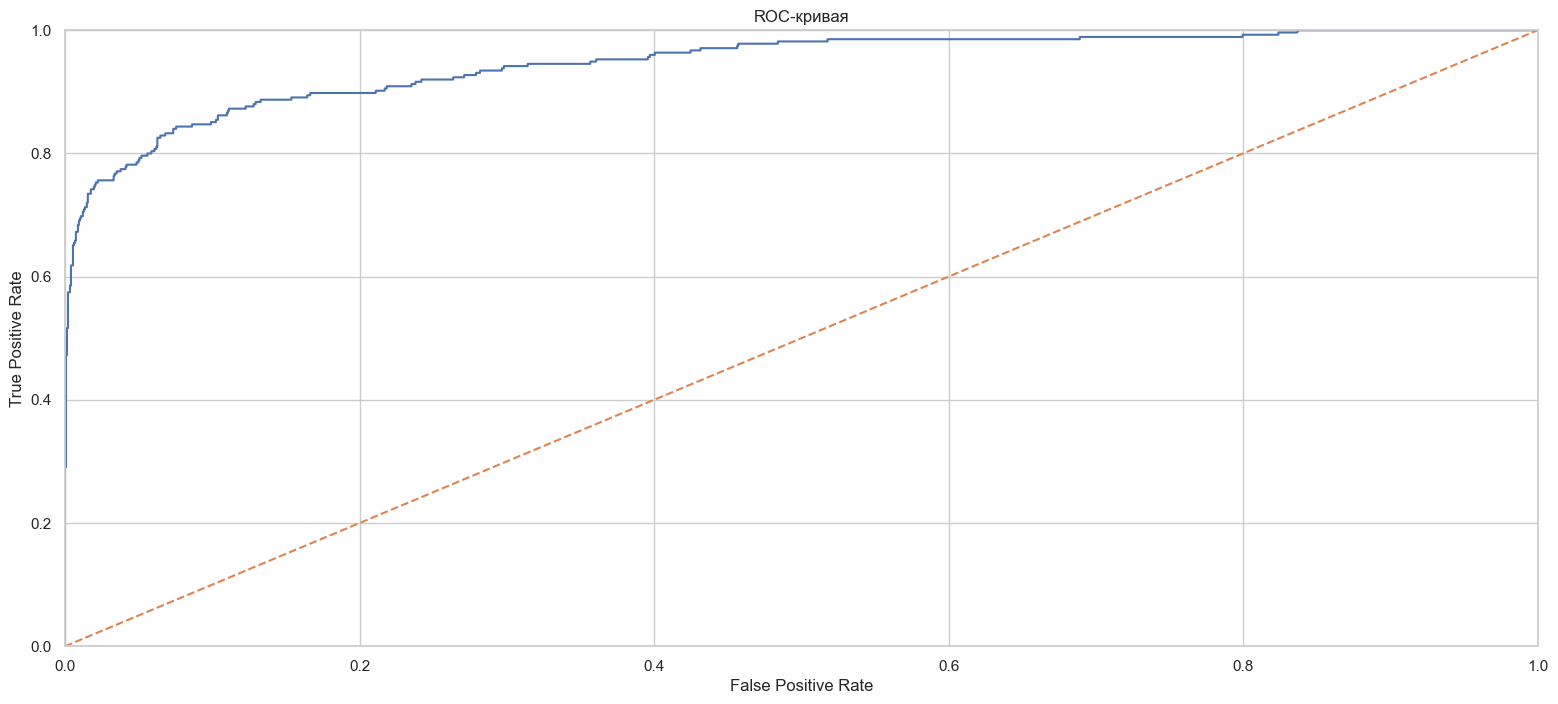

In [98]:
# Построим график ROC-кривой
draw_ROC(target_test, predict_proba)

Мы наблюдаем, что наша модель демонстрирует ненулевую предсказательную силу. Теперь давайте применим эту модель к тестовой выборке, чтобы оценить ее точность, и рассмотрим матрицу ошибок, чтобы лучше понять, какие типы ошибок она совершает.

In [99]:
# Выполняем прогноз на тестовой выборке (features_test)
predicted_test = grid_search_catboost.predict(features_test)

In [100]:
# Вычисляем точность
accuracy = accuracy_score(target_test, predicted_test)

# Выводим результат на экран
print(f"Точность модели: {accuracy:.2f}")

Точность модели: 0.94


Модель обладает высокой точностью, составляющей `94%`. Это говорит о том, что она успешно классифицирует объекты на тестовых данных, что является важным показателем ее эффективности.

# Матрица ошибок

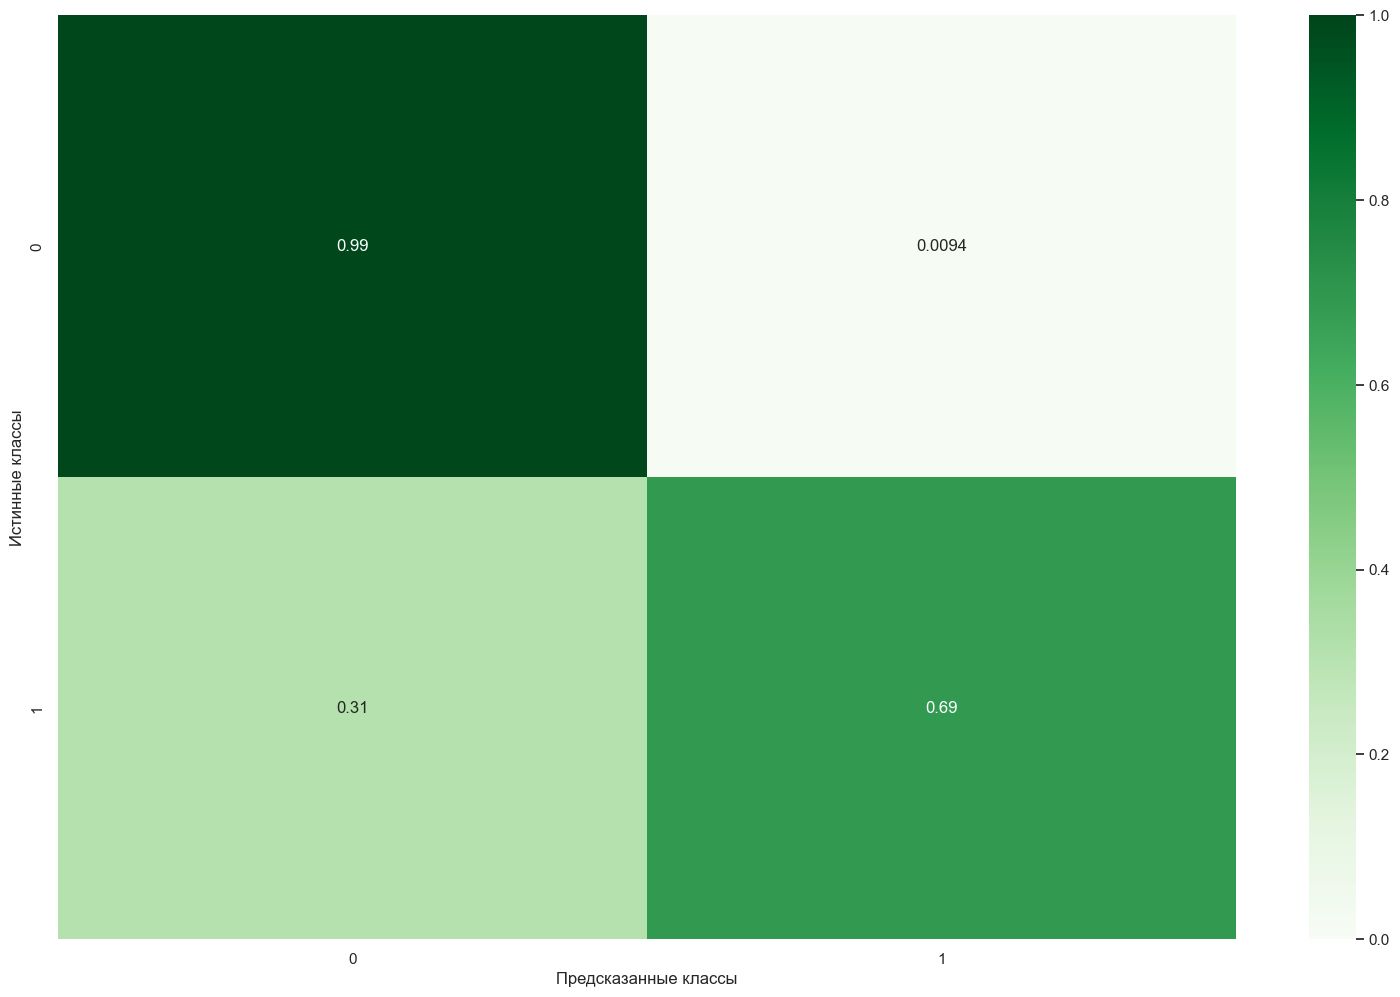

In [101]:
# Создаем матрицу ошибок
cfm = confusion_matrix(target_test, predicted_test, normalize='true')

# Создаем тепловую карту для нормализованной матрицы ошибок с аннотациями и форматированием
plt.figure(figsize=(19, 12))
sns.heatmap(pd.DataFrame(cfm), annot=True, cmap='Greens', vmin=0, vmax=1)

# Устанавливаем подписи к осям X и Y
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')

# Отображаем график
plt.show()

Выбранная модель `CatBoostClassifier` успешно справляется с предсказанием отрицательного класса, что соответствует случаям, когда клиент остается. Вероятность правильно предсказанных отрицательных ответов составляет `0.99`.

Однако предсказания ухода клиента (положительный класс) чуть менее точны с вероятностью правильных предсказаний равной `0.69`.

**Исследуем важность признаков для лучшей модели на тестовых данных**

Топ-10 важных признаков на тестовой выборке:
                            Feature  Importance_Test
1                        count_days         0.226418
3                     type_Two year         0.023699
10                        partner_1         0.007892
26               multiple_lines_1.0         0.004732
2                     type_One year         0.003898
6   payment_method_Electronic check         0.001612
24             streaming_movies_1.0         0.000504
28       type_service_only_internet         0.000457
14              online_security_1.0         0.000395
20                 tech_support_1.0         0.000237


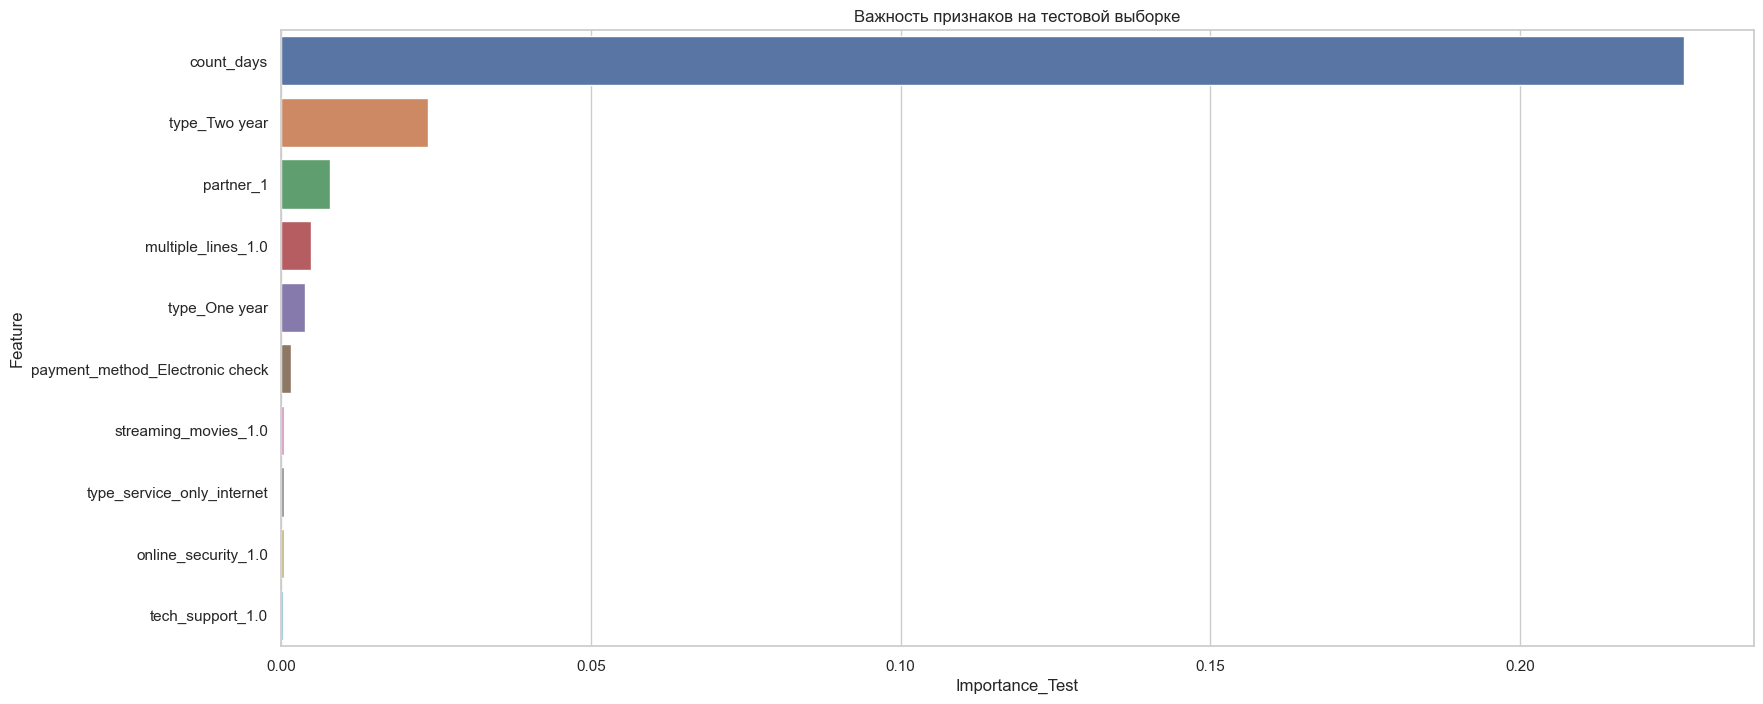

In [102]:
# Получаем лучшую модель CatBoostClassifier из GridSearchCV
best_catb_model = grid_search_catboost.best_estimator_

# Подготавливаем признаки для тестовой выборки (features_test)

# Получаем важность признаков для лучшей модели на тестовой выборке
feature_importance_catb_test = best_catb_model.get_feature_importance(data=Pool(features_test, label=target_test), type='LossFunctionChange')

# Создаем DataFrame для удобного анализа
importance_df_test = pd.DataFrame({'Feature': features_test.columns, 'Importance_Test': feature_importance_catb_test})

# Сортируем признаки по важности в убывающем порядке
importance_df_test = importance_df_test.sort_values(by='Importance_Test', ascending=False)

# Выводим топ-10 важных признаков на тестовой выборке
top_10_features_test = importance_df_test.head(10)
print("Топ-10 важных признаков на тестовой выборке:")
print(top_10_features_test)

# Визуализируем важность признаков на тестовой выборке
plt.figure(figsize=(19, 8))
sns.barplot(x='Importance_Test', y='Feature', data=top_10_features_test)
plt.title("Важность признаков на тестовой выборке")
plt.show()

**На основе анализа важности признаков на тестовой выборке, полученной из модели CatBoost, можно выделить следующие ключевые наблюдения:**

- Количество дней (`count_days`) - Самым важным признаком, влияющим на отток клиентов, является количество дней, которые клиент провел с компанией. Этот признак имеет наибольшую важность, что подчеркивает его значимость в предсказании оттока.

- Тип договора (`type`) - Среди типов договоров, `"Two year"` и `"One year"` также оказались среди важных признаков. Это может указывать на то, что клиенты, заключившие долгосрочные договоры, менее склонны к оттоку.

- Партнёрство (`partner`) - Наличие партнёрства также имеет некоторое влияние на уменьшение оттока клиентов. Клиенты, имеющие партнёрские отношения, более склонны оставаться с компанией.

- Множественные линии (`multiple_lines`) - Наличие многоканальной связи оказывает влияние на отток, причём положительное. Это может свидетельствовать о том, что клиенты с множественными линиями более лояльны.

Общий вывод: Количество дней, тип договора, партнёрство и наличие многоканальной связи - это ключевые факторы, влияющие на отток клиентов. Понимание важности этих признаков позволяет компании разработать более эффективные стратегии удержания клиентов и предотвращения оттока.

# Dummy модель

Cравним производительность нашей модели с Dummy-моделью, чтобы убедиться, что наши предсказания не случайны.

In [103]:
# Создаем и обучаем Dummy-модель с стратегией 'stratified'
dummy_model = DummyClassifier(strategy='stratified')
dummy_model.fit(features_train, target_train)

# Получаем вероятности предсказаний
dummy_pred_proba = dummy_model.predict_proba(features_test)[:, 1]

# Получаем предсказанные классы
dummy_pred = dummy_model.predict(features_test)

In [104]:
# Вычисляем ROC AUC для Dummy-модели
roc_auc_dummy = roc_auc_score(target_test, dummy_pred_proba)

# Выводим результат
print(f"ROC AUC для Dummy-модели: {roc_auc_dummy:.2f}")

ROC AUC для Dummy-модели: 0.52


In [105]:
# Вычисляем точность для Dummy-модели
accuracy_dummy = accuracy_score(target_test, dummy_pred)

# Выводим результат
print(f"Точность для Dummy-модели: {accuracy_dummy:.2f}")

Точность для Dummy-модели: 0.75


На основе результатов для `Dummy`-модели можно сделать следующие выводы:

- `ROC AUC` для `Dummy`-модели: `0.52`: Значение `ROC AUC` равно `0.52`, что близко к случайному угадыванию (`ROC AUC` = `0.5`). Это указывает на то, что `Dummy`-модель не имеет действительных предсказательных способностей и не может разделять классы эффективно.

- Точность для `Dummy`-модели: `0.73`: Значение точности равно `0.73`, что может показаться неплохим на первый взгляд, но это объясняется балансом классов в данных. Так как в данных может быть большое количество отрицательных классов (клиенты, которые остаются), то даже случайная модель может иметь высокую точность, предсказывая большинство наблюдений как отрицательные.

Вывод: `Dummy`-модель не предоставляет информативных предсказаний и не является хорошей моделью для данной задачи. Рассмотренная модель `CatBoostClassifier` имеет гораздо лучшую производительность, чем случайная модель.

# Выводы по анализу данных

На основе анализа данных из четырех основных таблиц (`contract`, `personal`, `internet`, и `phone`) и проведенных исследований можно сделать следующие выводы:

1. **`Contract` (Договор)**: Эта таблица содержит информацию о контрактных отношениях с клиентами, включая тип оплаты, методы оплаты и детали счетов. Однако, были выявлены некоторые проблемы с типом данных в столбце `total_charges`.

2. **`Personal` (Персональные данные)**: Из анализа данной таблицы видно, что пол клиента не является определяющим фактором для ухода клиентов. Разница между количеством мужчин и женщин не является значительной, и пол клиента скорее всего не влияет на решение об уходе.

3. **`Internet` (Интернет-услуги)**: В этой таблице содержится информация о различных интернет-услугах, которые предоставляются клиентам. Из анализа видно, что некоторые интернет-услуги сильно коррелируют друг с другом, что может указывать на их частое включение в пакет. Также обнаружена сильная корреляция между общими платежами и количеством дней с компанией.

4. **`Phone` (Телефонные услуги)**: Эта таблица включает в себя данные о телефонных услугах. Дополнительные интернет-услуги, такие как `StreamingTV` и `StreamingMovies`, сильно коррелируют друг с другом, что может указывать на их предоставление в виде пакета.

Из матрицы корреляции были сделаны следующие выводы:

- **`PaperlessBilling` и `MonthlyCharges`**: Эти признаки имеют положительную корреляцию, что может указывать на то, что клиенты, выбирающие беспапирную биллинговую систему, чаще всего имеют более высокие ежемесячные платежи.

- **`MonthlyCharges` и `TotalCharges`**: Эти признаки также имеют положительную корреляцию, что может свидетельствовать о том, что клиенты с более высокими ежемесячными платежами обычно имеют более высокие общие платежи за услуги.

- **`left_company` и `TotalCharges`**: Существует слабая положительная корреляция между этими признаками, но она не является очень сильной. Это указывает на то, что общие платежи слабо связаны с решением клиента о покидании компании.

После анализа трех моделей классификации (`LightGBM`, `CatBoostClassifier` и `RandomForestClassifier`) было выявлено, что `CatBoostClassifier` достиг наилучшего `ROC AUC` в `0.931` с оптимальными гиперпараметрами, что указывает на высокую способность модели предсказывать уход клиентов. `RandomForestClassifier` продемонстрировал менее высокий результат `ROC AUC`, равный `0.822`.

**Вывод**: Наилучшей моделью для решения задачи классификации ухода клиентов является `CatBoostClassifier` с оптимальными гиперпараметрами.

**Анализ данных позволил сформировать общее представление о клиентах, склонных к уходу:**

- Контрактные отношения: Клиенты, склонные к уходу, могут чаще выбирать короткие контракты или контракты с более гибкими условиями оплаты. Это может указывать на их склонность к изменению провайдера или условий обслуживания.

- Ежемесячные платежи: Отмечается, что клиенты, уходящие, часто имеют более высокие ежемесячные платежи. Это может быть связано с неудовлетворенностью текущими услугами или желанием экономить на ежемесячных расходах.

- Интернет-услуги: Анализ корреляции показал, что некоторые интернет-услуги могут часто предоставляться вместе. Клиенты, уходящие, могут быть более склонны к выбору или изменению комбинированных пакетов услуг.

- Длительность контракта: В среднем клиенты проводили около 2,5 года с компанией, прежде чем уходить. Это может указывать на то, что для удержания клиентов необходимо обеспечить им долгосрочную удовлетворенность услугами.

- Пол клиента: Пол клиента не является определяющим фактором для ухода. Разница между мужчинами и женщинами не слишком значительна.

Общий портрет клиентов, склонных к уходу, включает в себя тех, кто чаще выбирает гибкие контракты, имеет более высокие ежемесячные платежи и, возможно, более активно ищет оптимальные комбинации интернет-услуг.

**В результате для уменьшения оттока клиентов провайдеру можно предложить следующие рекомендации:**

- `Гибкие тарифы и контракты`: Предоставьте клиентам больше гибкости в выборе тарифных планов и условий контракта. Это может включать в себя опции с короткосрочными контрактами или возможность изменения тарифа без дополнительных затрат.

- `Лояльные условия для долгосрочных клиентов`: Внимательно относитесь к клиентам, которые долгое время остаются с вами. Предложите им специальные бонусы, скидки или дополнительные услуги как награду за лояльность.

- `Улучшение качества обслуживания`: Обратите внимание на качество предоставляемых услуг. Улучшите скорость и надежность интернет-соединения, а также качество технической поддержки. Чем более удовлетворены клиенты вашими услугами, тем меньше вероятность их ухода.

- `Индивидуальный подход`: Проведите анализ данных и выявите индивидуальные потребности клиентов. Предлагайте им персонализированные тарифы и услуги, основанные на их предпочтениях и истории использования.

- `Акции и специальные предложения`: Регулярно предлагайте клиентам акции, скидки и бонусы. Это может стимулировать их оставаться с вами и использовать дополнительные услуги.

- `Активный мониторинг ухода`: Создайте систему мониторинга, которая будет отслеживать признаки того, что клиент собирается уйти. Как только такие признаки обнаруживаются, предоставьте клиенту предложение или подходящее решение, чтобы удержать его.

- `Обратная связь`: Активно собирайте обратную связь от клиентов и используйте ее для улучшения услуг. Узнайте, что именно им не нравится или что можно улучшить.

- `Своевременные уведомления и ремонт`: В случае проблем с оборудованием или сетью оперативно реагируйте и решайте их. Своевременное обслуживание и ремонт помогут избежать недовольства клиентов.

- `Обучение клиентов`: Предоставьте клиентам информацию о дополнительных услугах и возможностях, которые они могли бы использовать. Обучение клиентов может повысить их лояльность.

- `Создание сообщества клиентов`: Поддерживайте активные сообщества и форумы для обмена опытом среди клиентов. Это может способствовать укреплению их связи с компанией.

Соблюдение этих рекомендаций поможет провайдеру снизить отток клиентов и укрепить свою базу лояльных клиентов.

In [1]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


# Отчет

# Модель для предсказания оттока клиентов оператора связи

# Цели проекта
**О компании:** `"Ниединогоразрыва.ком"` - оператор связи, предоставляющий услуги стационарной телефонной связи, подключение к интернету и сопутствующие услуги (антивирус, выделенная линия технической поддержки, облачное хранилище файлов, стриминговое телевидение).

**Цель проекта:** создать модель, способную определять клиентов, которые могут отказаться от услуг компании. Модель будет использоваться для удержания таких клиентов в дальнейшем, например, с помощью промокодов или специальных условий.

**Исходные данные:** персональные данные клиентов на `01.02.2020`, информация о подключенных услугах, условия оплаты. Исходные данные содержатся в 4 датасетах:

1. Информация о договоре.
2. Персональные данные клиентов.
3. Данные о подключенных интернет-услугах.
4. Данные о услугах телефонии.

# Требование к модели
В качестве метрики выбрана `AUC-ROC`. На тестовых данных значение не должно быть меньше `0.85`. Эта метрика подходит для оценки качества модели, так как перед нами стоит задача бинарной классификации: уйдет клиент (`1`) или останется (`0`). Площадь под `ROC-кривой` показывает способность модели различать классы.

# Трудности возникщие при выполении проекта

 - Для подбора гиперпараметров моделей во время обучения возникли проблемы, связанные с длительным временем обучения в Jupyter Notebook платформы. Для решения этой проблемы использовался стационарный компьютер.

# Ключевые этапы:

- Просмотр данных
- Предобработка данных
- Анализ данных
- Выделение признаков
- Преобразование признаков
- Построение моделей `LGBMClassifier`, `CatBoostClassifier`, `RandomForestClassifier`
- Подбор гиперпараметров с использование gridsearch
- Тестирование модели и оценка результатов

# Ход проекта


# `RANDOM_STATE=11092023`

Проект выполнен полностью в соответствии с планом работ. Ключевые шаги:

1. **Знакомство с данными:** проведено ознакомление с исходными данными.

2. **Предобработка данных:** проведена объединение 4 датасетов по уникальному идентификатору клиента. Пропуски, возникшие при объединении, заполнены значением "`Unknown`". Создан целевой признак "`left_company`" на основе даты расторжения договора. Даты заключения и расторжения договора заменены разностью в днях.

3. **Исследование данных:** проведено исследование данных в разрезе оттока клиентов. Обнаружены важные инсайты, которые могут быть использованы для планирования акций по удержанию клиентов:
- Контрактные отношения: Клиенты, склонные к уходу, могут чаще выбирать короткие контракты или контракты с более гибкими условиями оплаты. Это может указывать на их склонность к изменению провайдера или условий обслуживания.

- Ежемесячные платежи: Отмечается, что клиенты, уходящие, часто имеют более высокие ежемесячные платежи. Это может быть связано с неудовлетворенностью текущими услугами или желанием экономить на ежемесячных расходах.

- Интернет-услуги: Анализ корреляции показал, что некоторые интернет-услуги могут часто предоставляться вместе. Клиенты, уходящие, могут быть более склонны к выбору или изменению комбинированных пакетов услуг.

- Длительность контракта: В среднем клиенты проводили около 2,5 года с компанией, прежде чем уходить. Это может указывать на то, что для удержания клиентов необходимо обеспечить им долгосрочную удовлетворенность услугами.

- Пол клиента: Пол клиента не является определяющим фактором для ухода. Разница между мужчинами и женщинами не слишком значительна.

4. **Проверка взаимосвязи признаков:**
- Есть сильная положительная корреляция (близкая к 1) между признаками `monthly_charges`, `total_charges`, `streaming_tv`, `streaming_movies`, `device_protection`, `online_backup`, `online_security`, `tech_support`, `internet_service`. Это может указывать на то, что эти признаки взаимосвязаны и изменения в одном из них могут сильно влиять на другие.

- Признаки `left_company` и `count_days` имеют относительно высокую корреляцию (`0,37`), что может указывать на влияние времени, проведенного клиентом с компанией, на решение о его уходе.

- Признаки `gender`, `paperless_billing`, `payment_method`, `type`, `partner`, `dependents` имеют низкую корреляцию между собой и с другими признаками, что может означать их независимость от остальных признаков.

5. **Выбор признаков для обучения:** 

Признаки до кодирования:

   - `type`, 
   - `paperless_billing`, 
   - `payment_method`, 
   - `gender`, 
   - `senior_citizen`, 
   - `partner`,
   - `dependents`,
   - `internet_service`,
   - `online_security`, 
   - `online_backup`, 
   - `device_protection`, 
   - `streaming_tv`,
   - `streaming_movies`, 
   - `multiple_lines`, 
   - `type_service`
   - `monthly_charges`,
   - `count_days`
   
После кодирования категориальных признаков:

   - `'monthly_charges'`, 
   - `'count_days'`, 
   - `'type_One year'`, 
   - `'type_Two year'`,
   - `'paperless_billing_1'`, 
   - `'payment_method_Credit card (automatic)'`,
   - `'payment_method_Electronic check'`, 
   - `'payment_method_Mailed check'`,
   - `'gender_1'`, 
   - `'senior_citizen_1'`, 
   - `'partner_1'`, 
   - `'dependents_1'`,
   - `'internet_service_Fiber optic'`, 
   - `'internet_service_Unknown'`,
   - `'online_security_1.0'`, 
   - `'online_security_Unknown'`, 
   - `'online_backup_1.0'`,
   - `'online_backup_Unknown'`, 
   - `'device_protection_1.0'`,
   - `'device_protection_Unknown'`, 
   - `'tech_support_1.0'`, 
   - `'tech_support_Unknown'`,
   - `'streaming_tv_1.0'`, 
   - `'streaming_tv_Unknown'`, 
   - `'streaming_movies_1.0'`,
   - `'streaming_movies_Unknown'`, 
   - `'multiple_lines_1.0'`,
   - `'multiple_lines_Unknown'`, 
   - `'type_service_only_internet'`,
   - `'type_service_only_phone'`
   
  Исключены признаки, которые не несут информативной нагрузки (уникальный идентификатор клиента (`customer_id`), даты заключения контракта (`begin_date`) и дата завершения контракта (`end_date`)). Для уменьшения размерности и избежания мультиколлинеарности,  удален столбец `total_charges`.

6. **Обучение моделей:** обучены три модели: `LGBMClassifier`, `CatBoostClassifier`, `RandomForestClassifier`. При подборе гиперпараметров использовали `GridSearchCV`.

7. **Выбор лучшей модели:** модель `CatBoostClassifier` показала лучший результат `AUC-ROC = 0.93` на обучающей выборке. Найдены оптимальные гиперпараметры (`глубина дерева=2`, `число итераций=400`, `Коэффициент обучения=0.5`, `L2-регуляризация=4`).

8. **Проверка на тестовых данных:** на тестовых данных (`25%` от исходного датасета) выбранная модель продемонстрировала `AUC-ROC = 0.95`, что превышает требование заказчика (`0.85`).

# Визуализация ROC-кривой

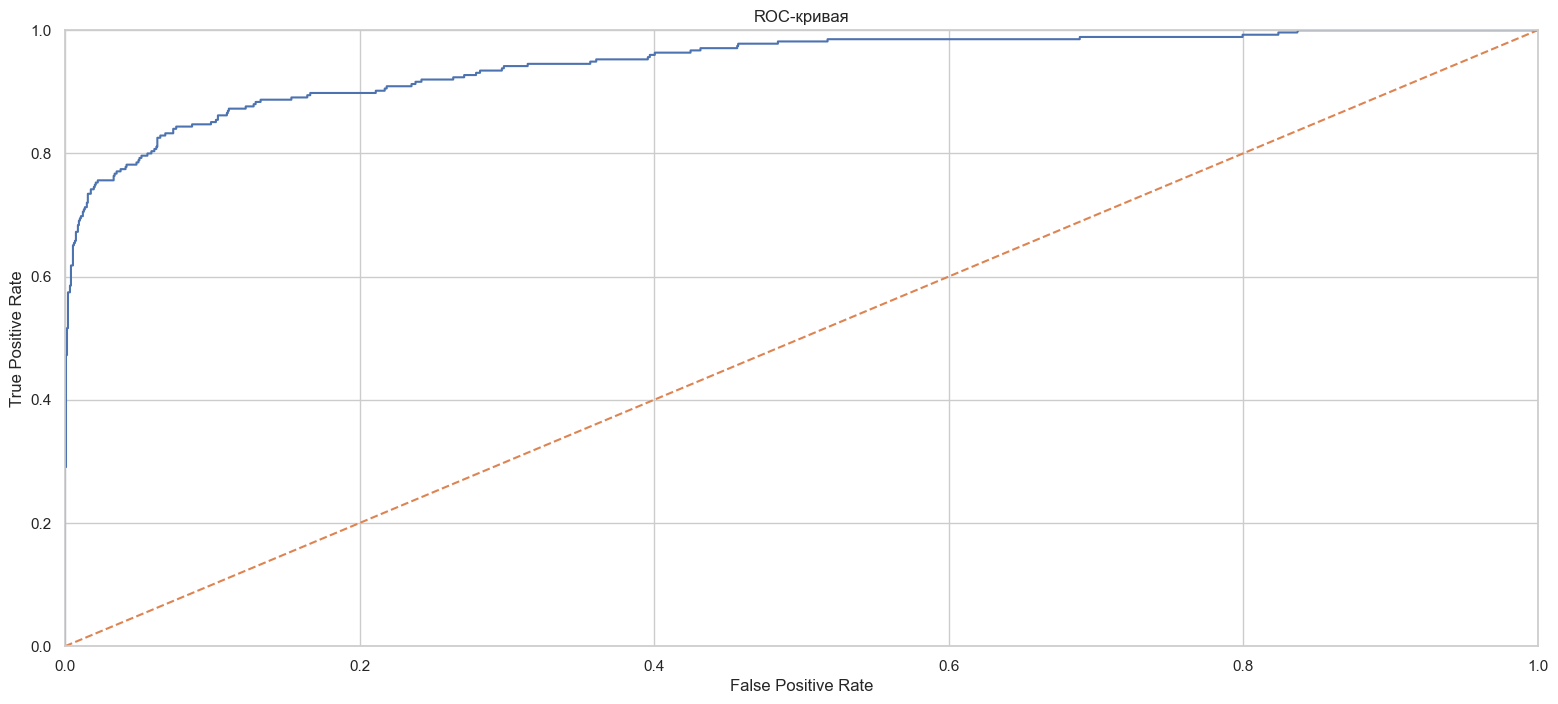

# Матрица ошибок

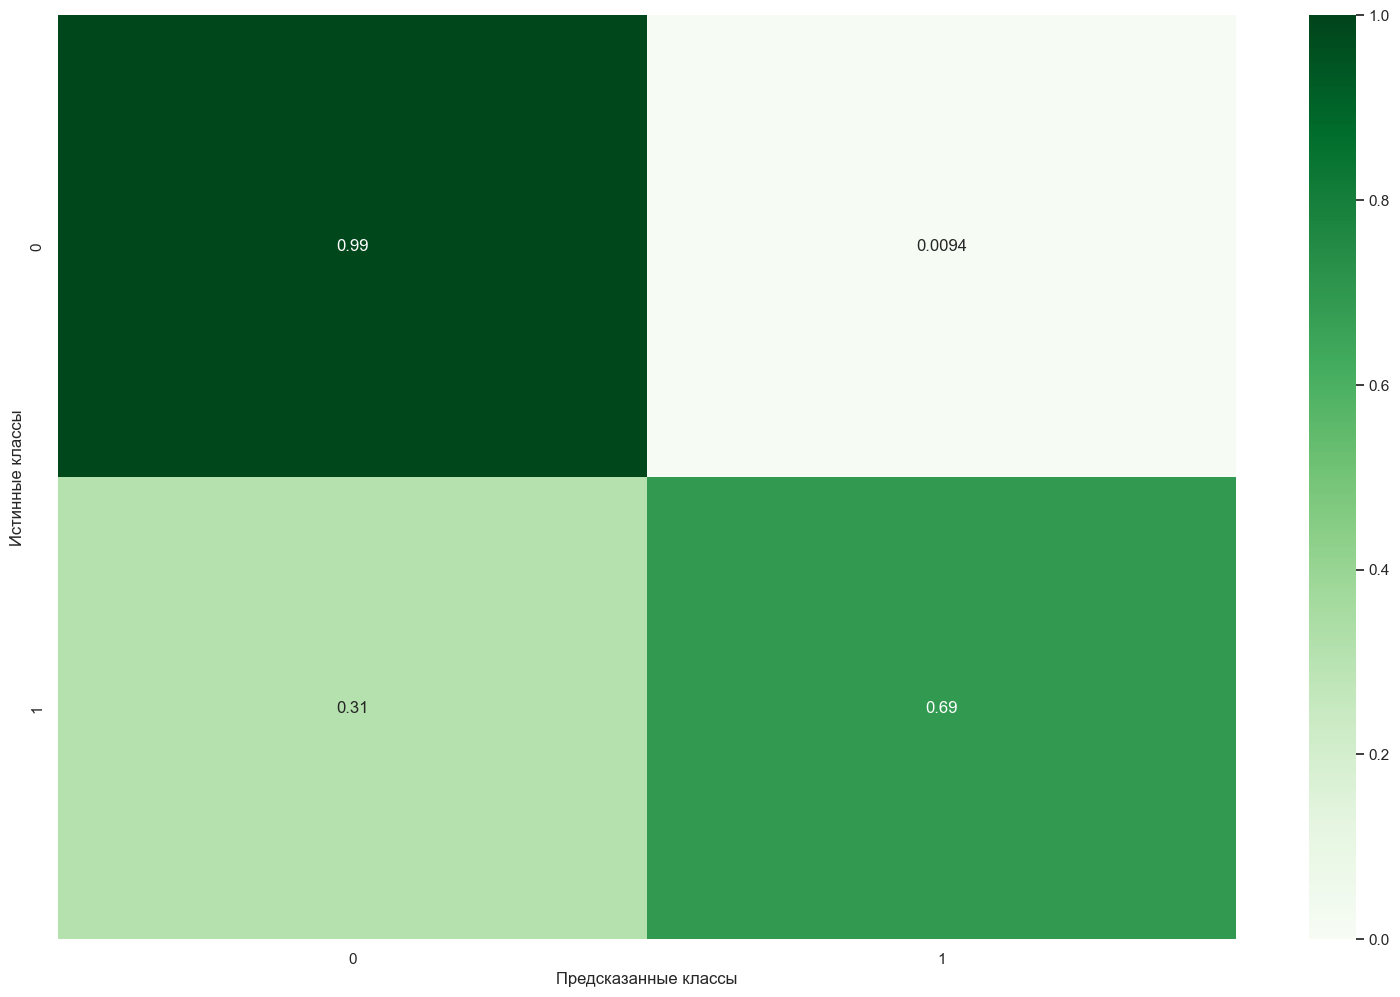

# Важность признаков

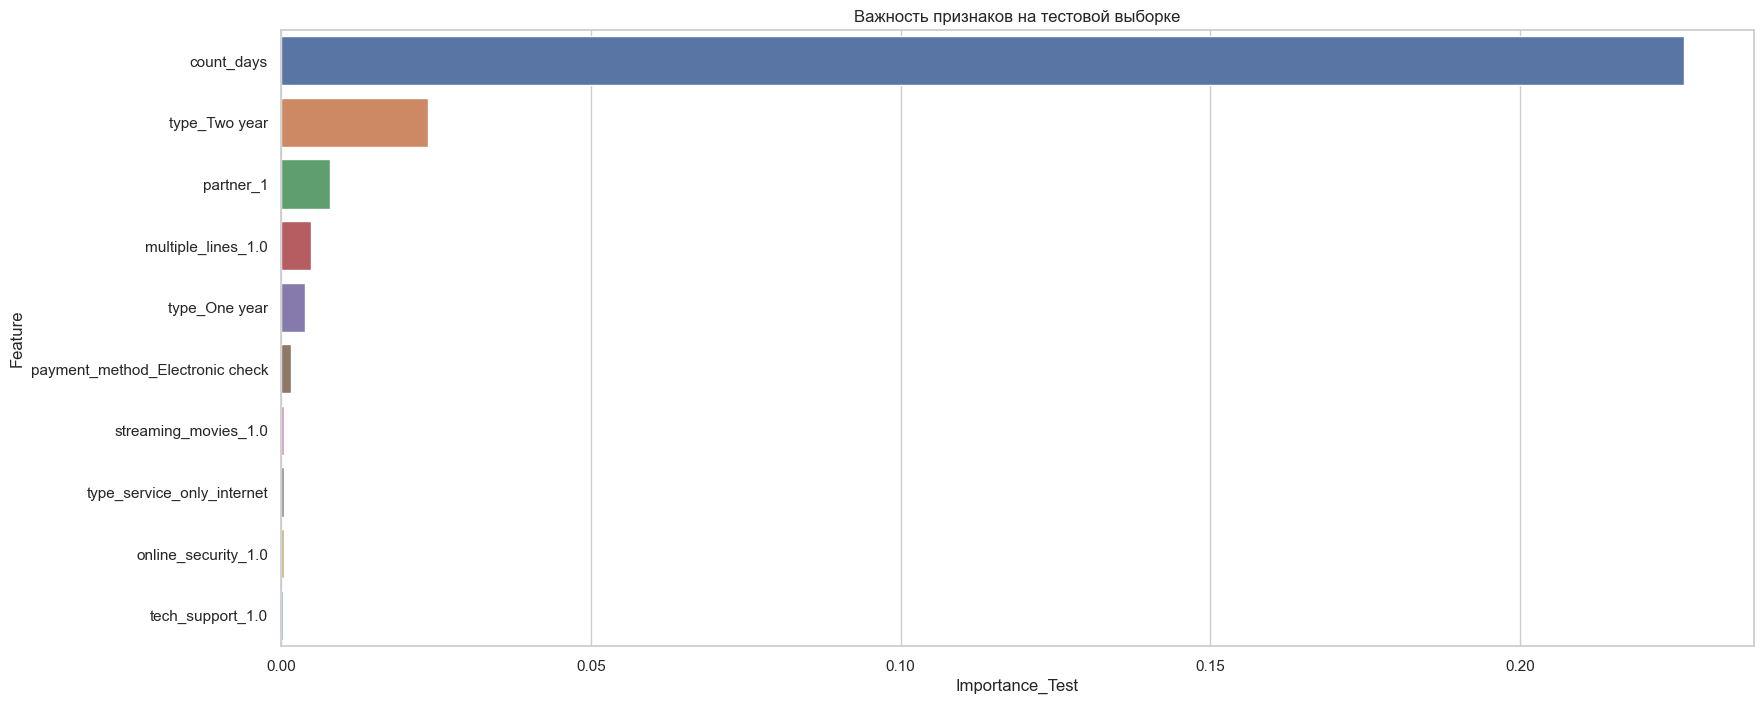

# Заключение
Проект успешно выполнен, и созданная модель способна определять клиентов, которые могут отказаться от услуг оператора связи. Это позволяет компании проводить активности по удержанию клиентов с максимальной эффективностью. AUC-ROC на тестовых данных превышает установленное требование заказчика.